In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

Using GPU!
Using GPU!
Using GPU!
No TPUs...


In [2]:
!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [3]:
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


#cpu = torch.ones(1).device

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)

In [4]:
u,v=lapOp.diagonalize()

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_utils/tensor.py:16: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  R = torch.cholesky(VTV, upper=True)  # (*BMV, nguess, nguess)
/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_impls/linalg/symeig.py:174: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion

In [4]:
#List layers : 
layers = [module for module in model.modules() if isinstance(module, nn.Sequential)]
for layer in layers:
    print(layer)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): FFNet(
    (linears): ModuleList(
      (0): Linear(in_features=784, out_features=50, bias=False)
      (1): Linear(in_features=50, out_features=50, bias=False)
      (2): Linear(in_features=50, out_features=10, bias=False)
    )
  )
)


# Spectrum with no training 

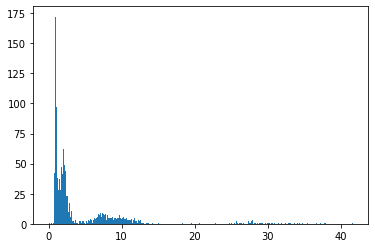

In [143]:
u = u.to('cpu')
plt.hist(u.numpy(),bins=300)
plt.show()

# Training the model 

In [6]:

optimizer = torch.optim.SGD
pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5)

Epoch 1
-------------------------------
Epoch training loss: 0.901131 	Epoch training accuracy: 74.55%                                      00 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.50%,                 Avg loss: 0.412757 



(0.4127569341460864, 88.5)

# Spectrum after training 

In [7]:
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)
uTrained,vTrained = lapOp.diagonalize()

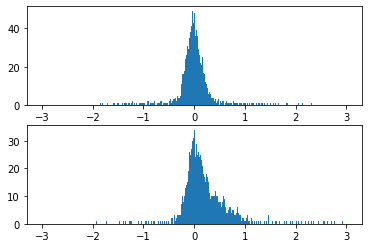

In [8]:
uTrained = uTrained.to('cpu')
plt.figure(1)
plt.subplot(211)
plt.hist(u.numpy(),bins=300,range=(-3,3))
plt.subplot(212)
plt.hist(uTrained.numpy(),bins=300,range=(-3,3))
plt.show()

# Spectrum evolution

Epoch 1
-------------------------------
Epoch training loss: 0.964565 	Epoch training accuracy: 72.54%                                                               
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.27%,                 Avg loss: 0.407202 

Epoch 1
-------------------------------
Epoch training loss: 0.349636 	Epoch training accuracy: 89.78%                                      500 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.36%,                 Avg loss: 0.299601 

Epoch 1
-------------------------------
Epoch training loss: 0.281609 	Epoch training accuracy: 91.83%                                                                
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 92.70%,                 Avg loss: 0.248616 



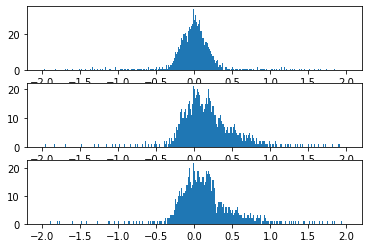

In [9]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=True))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 2


plt.figure(1)
epochs=epochs+1
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights)
    u,v = lapOp.diagonalize()
    plt.subplot(100*epochs + 11+i)
    plt.hist(u.to('cpu').numpy(),bins=300,range=(-2,2))
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(-0.0078, device='cuda:0')


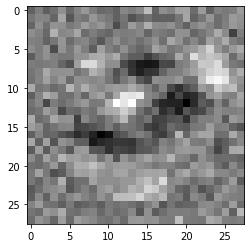

In [10]:
#Plotting eigenvectors 
idx = 6

img =-v.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')


print(u[285])

# With absolute value : 

Epoch 1
-------------------------------
Epoch training loss: 0.940808 	Epoch training accuracy: 72.74%                                      0 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.56%,                 Avg loss: 0.394223 

Epoch 1
-------------------------------
Epoch training loss: 0.348004 	Epoch training accuracy: 89.91%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.32%,                 Avg loss: 0.302348 



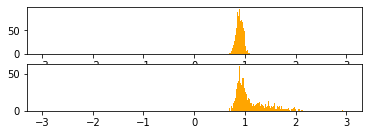

In [11]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='abs')
    uabs,vabs = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(uabs.to('cpu').numpy(),bins=300,range=(-3,3),color='orange')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(24.6742, device='cuda:0')


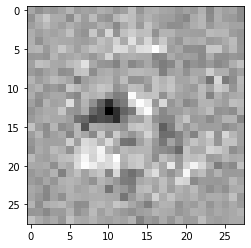

In [12]:
#Plotting eigenvectors 
idx = -8
print(uabs[idx])

img = vabs.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')



# With ReLU

Epoch 1
-------------------------------
Epoch training loss: 0.936106 	Epoch training accuracy: 73.65%                                      00 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.22%,                 Avg loss: 0.416524 

Epoch 1
-------------------------------
Epoch training loss: 0.346853 	Epoch training accuracy: 90.02%                                      500 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.30%,                 Avg loss: 0.297879 



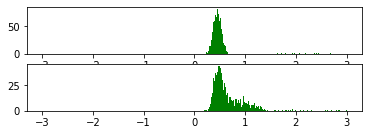

In [13]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    urelu,vrelu = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(urelu.to('cpu').numpy(),bins=300,range=(-3,3),color='green')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(1.8094, device='cuda:0')
torch.Size([894, 893])
tensor([-0.0033,  0.0428,  0.0209,  0.0426,  0.0167,  0.0122, -0.0249,  0.0258,
         0.0631,  0.0369], device='cuda:0')


tensor(8, device='cuda:0')

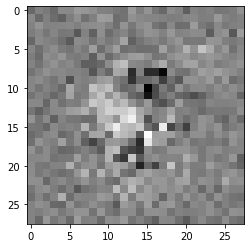

In [14]:
#Plotting eigenvectors 
idx = 789
print(urelu[idx])

img = vrelu.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

print(vrelu.shape)
print(-vrelu.T[idx][-10:])
(-vrelu.T[idx][-10:]).argmax()

In [15]:
torch.argmax(torch.abs(vrelu.T[-5][:10]))

tensor(6, device='cuda:0')

# High spectrum tests

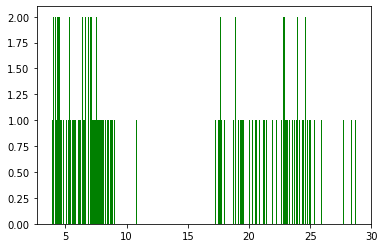

In [16]:
plt.hist(uabs.to('cpu')[28*28:].numpy(),bins=300,color='green')
plt.show()

In [17]:
import time 
#Plotting eigenvectors 
idx = 888
print(uabs[idx])


def saveEigenImages():
    i=28*28
    while i <893:
        idx = i 
        if vabs.T[idx][:28*28].mean()<(vabs.T[idx][:28*28].max()+vabs.T[idx][:28*28].min())/2:
            vabs.T[idx]=-vabs.T[idx]
        img = vabs.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayer' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 


tensor(25.3425, device='cuda:0')


In [18]:
!ls

basic_tutorial_gridsearch_benchmarking.ipynb  Ensemble_learning.ipynb
basic_tutorial_image.ipynb		      Intersection_Homology.ipynb
basic_tutorial_QandA.ipynb		      lapInputLayer
basic_tutorial_regression.ipynb		      lapInputLayerBin
basic_tutorial_tabular.ipynb		      lapInputLayer.zip
basic_tutorial_textClass.ipynb		      LaplacianSpectralAnalysis.ipynb
basic_tutorial_translation.ipynb	      optimising_topology.ipynb
compactification.ipynb			      orbit_5k_train.ipynb
data					      runs
decision_boundary_tori.ipynb		      TopactivationFC_tutorial.ipynb


# Binary mode

In [19]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from gdeep.data import DataLoaderFromArray
from torch.utils.data import DataLoader, random_split


writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")

dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


dataset = datasets.MNIST(root='./data',transform=ToTensor())
idx  = torch.logical_or(dataset.targets==4,dataset.targets==6)
dataset.targets = ((dataset.targets[idx]-4)/2).int()
dataset.data = dataset.data[idx]


my_dl = DataLoader(dataset)


train_len = int(len(dataset)*5/6)
train_set, test_set = random_split(dataset, [train_len, int(len(dataset)) - train_len])

dl_tr2 = DataLoader(train_set, batch_size=32, shuffle=True) # Train dataloader
dl_ts2 = DataLoader(test_set, batch_size=32, shuffle=False) # Test set 


""" Crappy stuff 
j = int(len(data)*5/6) 
print(data.type())


dl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])
dl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)



#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]
    
#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]

print(len(dl_tr),len(dl_ts))
print(len(dl_tr2),len(dl_ts2))
"""

' Crappy stuff \nj = int(len(data)*5/6) \nprint(data.type())\n\n\ndl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])\ndl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)\n\n\n\n#dl_tr2.dataset = [(x[0],int(x[1].item())) for x in dl_tr2.dataset]\n    \n#dl_ts2.dataset = [(x[0],int(x[1].item())) for x in dl_ts2.dataset]\n\nprint(len(dl_tr),len(dl_ts))\nprint(len(dl_tr2),len(dl_ts2))\n'

In [20]:
for x in dl_ts2.dataset:
    print(x[0].type())
    break 

torch.FloatTensor


Epoch 1
-------------------------------
Epoch training loss: 0.561891 	Epoch training accuracy: 88.95%                                       ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.42%,                 Avg loss: 0.144713 

Epoch 1
-------------------------------
Epoch training loss: 0.062705 	Epoch training accuracy: 98.64%                                      5 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.78%,                 Avg loss: 0.046441 

Epoch 1
-------------------------------
Epoch training loss: 0.037686 	Epoch training accuracy: 98.84%                                      45 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 98.57%,                 Avg loss: 0.040967 

Epoch 1
-------------------------------
Epoch training loss: 0.032398 	Epoch t

Validation results: 
 Accuracy: 99.85%,                 Avg loss: 0.009595 

Epoch 1
-------------------------------
Epoch training loss: 0.008626 	Epoch training accuracy: 99.83%                                      5 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.95%,                 Avg loss: 0.003530 

Epoch 1
-------------------------------
Epoch training loss: 0.007348 	Epoch training accuracy: 99.80%                                      245 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.95%,                 Avg loss: 0.005634 

Epoch 1
-------------------------------
Epoch training loss: 0.005756 	Epoch training accuracy: 99.91%                                      45 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 99.80%,                 Avg loss: 0.007356

Epoch training loss: 0.000313 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000404 

Epoch 1
-------------------------------
Epoch training loss: 0.000334 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000256 

Epoch 1
-------------------------------
Epoch training loss: 0.000320 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000295 

Epoch 1
-------------------------------
Epoch training loss: 0.000302 	Epoch training accuracy: 100.00%                                        

Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000154 

Epoch 1
-------------------------------
Epoch training loss: 0.000179 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000148 

Epoch 1
-------------------------------
Epoch training loss: 0.000168 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000172 

Epoch 1
-------------------------------
Epoch training loss: 0.000153 	Epoch training accuracy: 100.00%                                                    
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 100.00%,                 Avg loss: 0.000225 

Epoch 1
-----------------

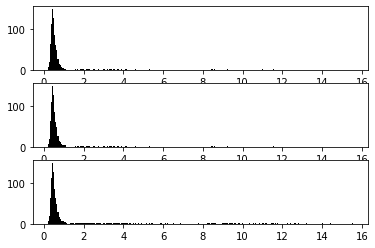

In [21]:


arch = [28*28, 50, 50, 50, 2]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr2, dl_ts2), loss_fn, writer)


epochs = 3
overfit = True


if overfit:
    for epoch in range(150):
         pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)

plt.figure(1)
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    ubin,vbin = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(ubin.to('cpu').numpy(),bins=300,color='black')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

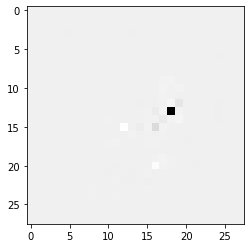

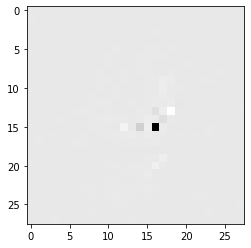

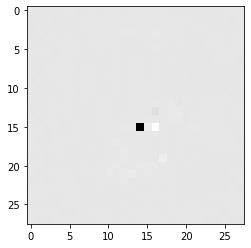

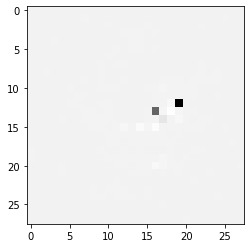

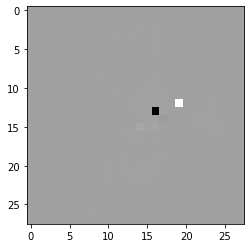

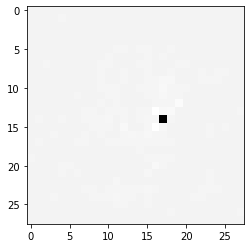

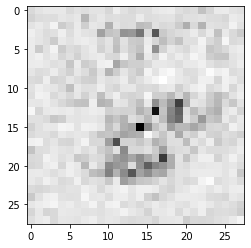

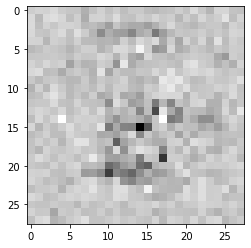

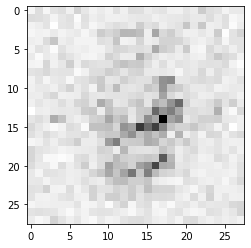

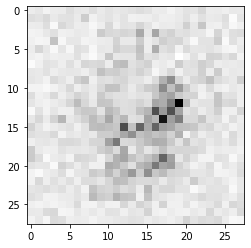

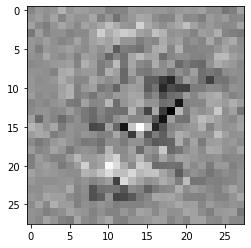

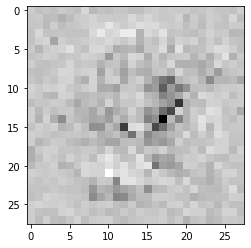

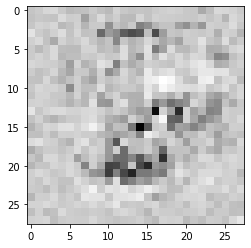

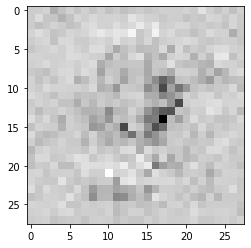

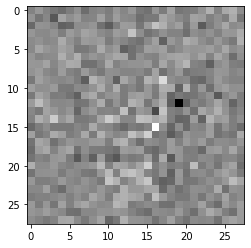

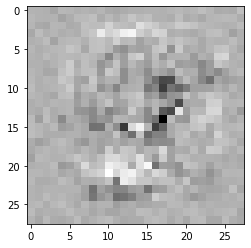

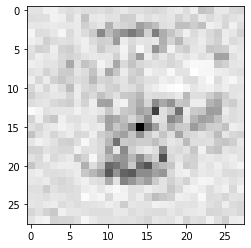

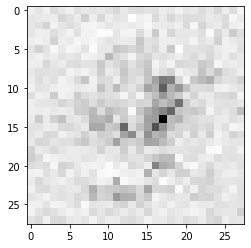

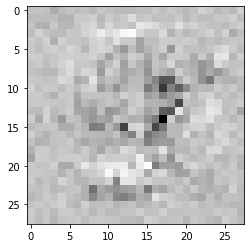

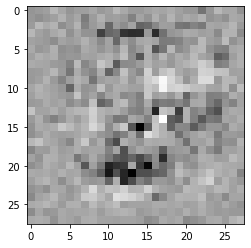

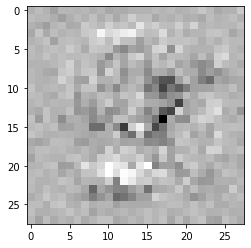

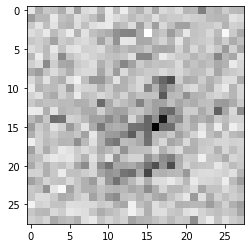

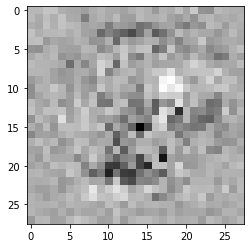

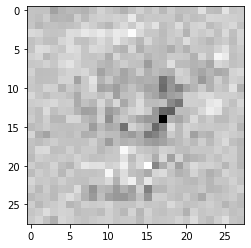

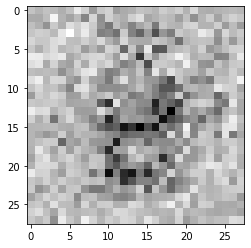

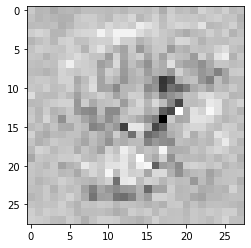

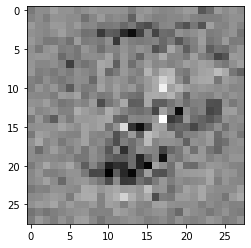

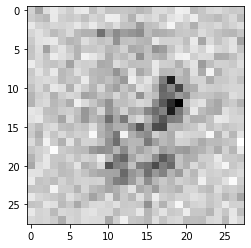

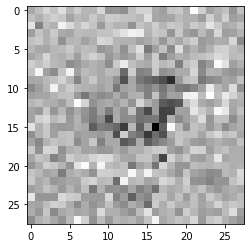

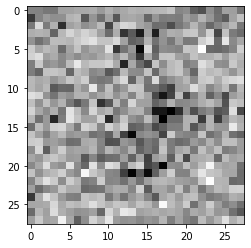

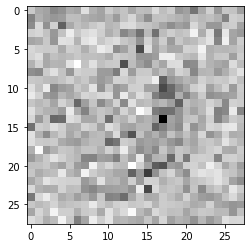

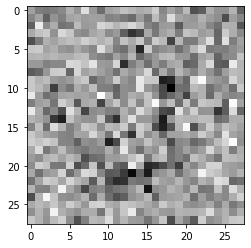

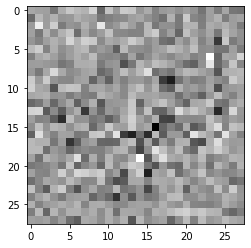

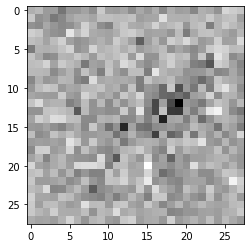

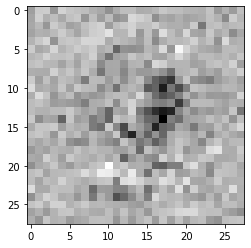

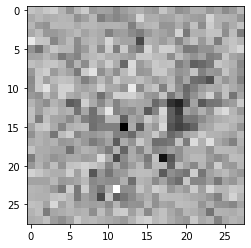

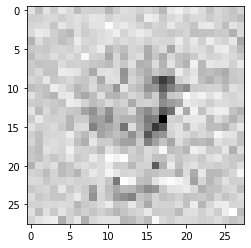

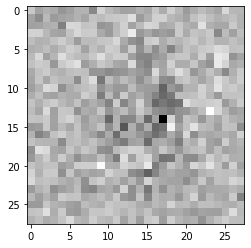

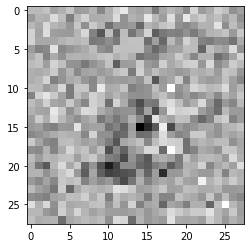

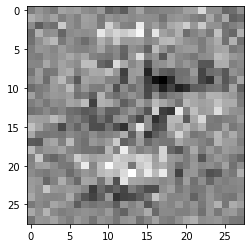

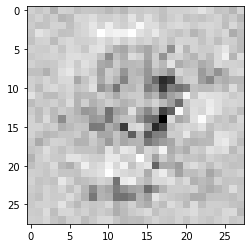

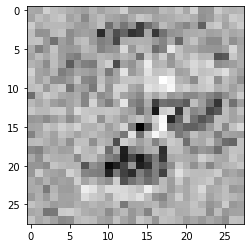

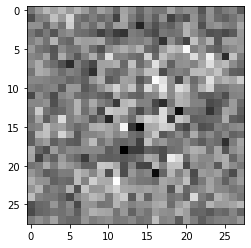

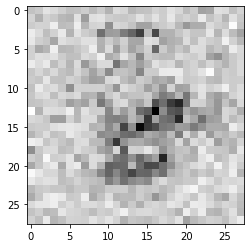

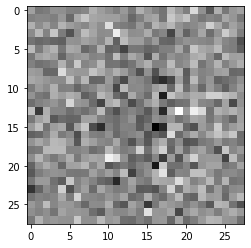

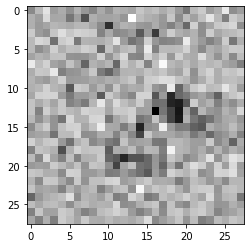

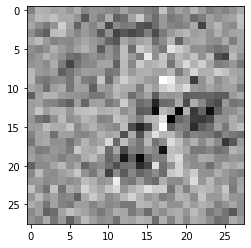

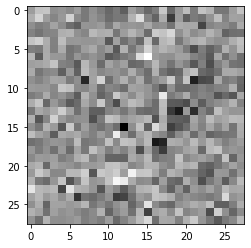

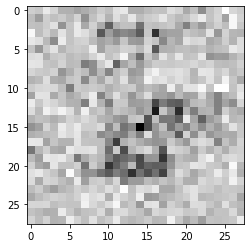

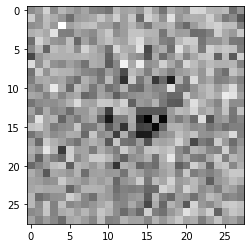

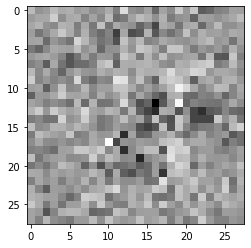

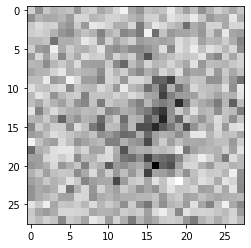

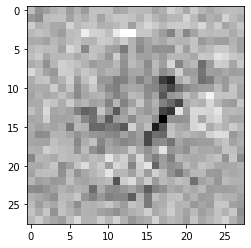

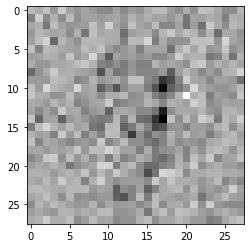

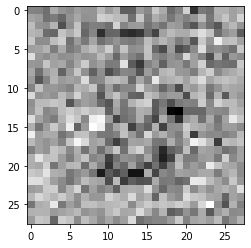

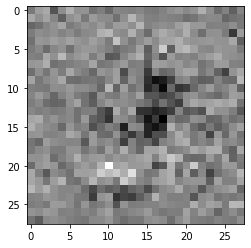

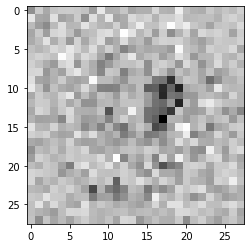

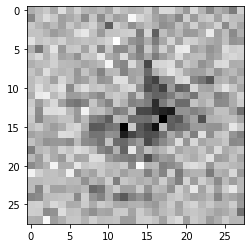

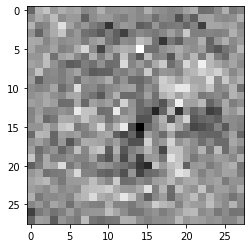

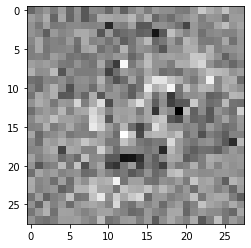

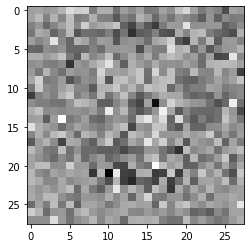

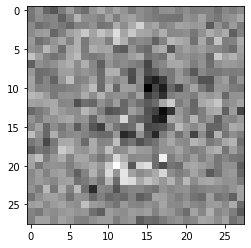

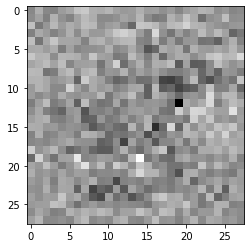

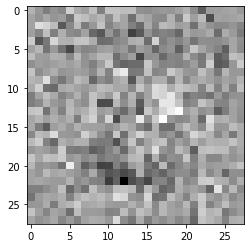

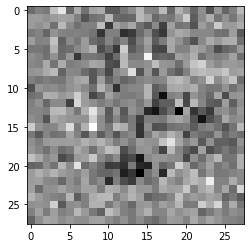

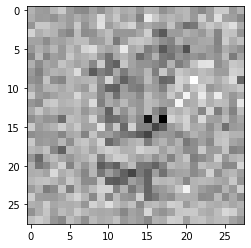

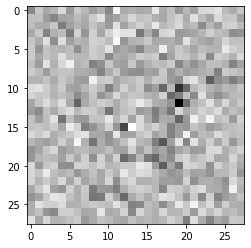

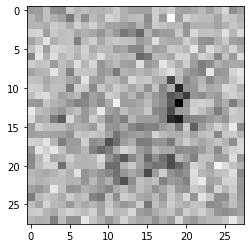

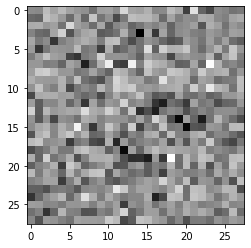

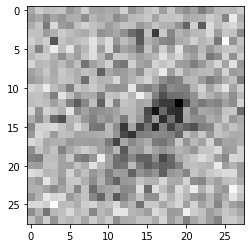

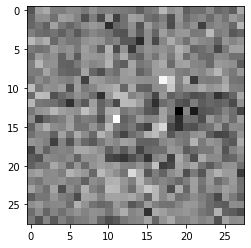

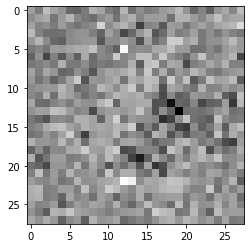

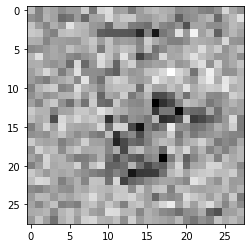

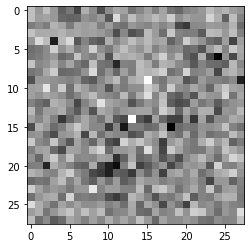

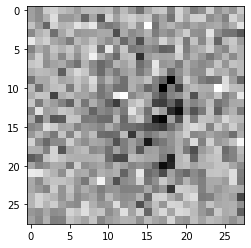

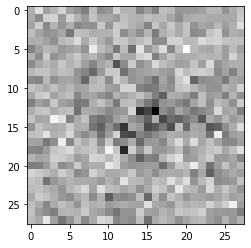

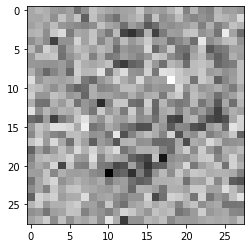

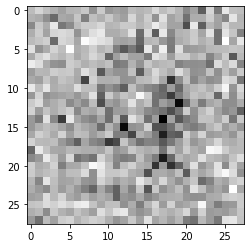

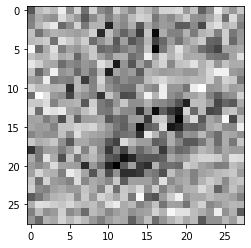

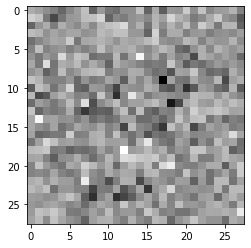

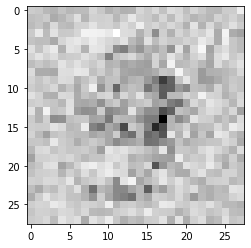

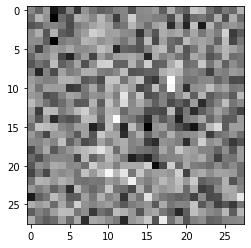

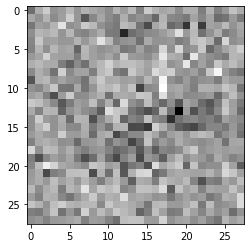

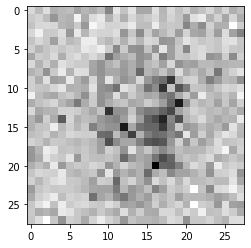

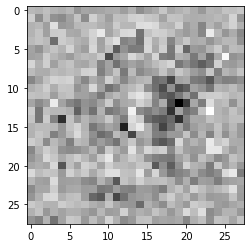

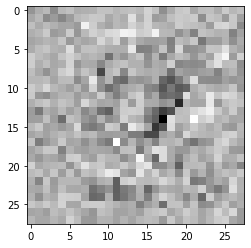

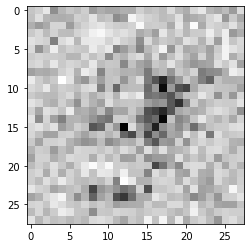

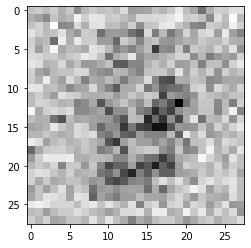

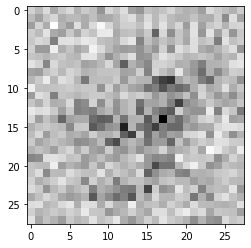

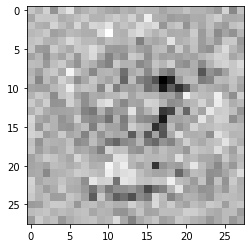

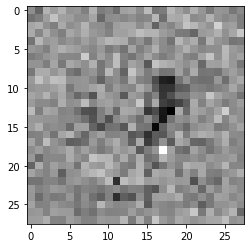

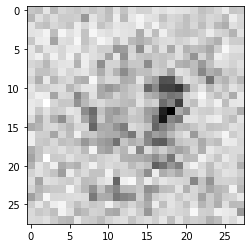

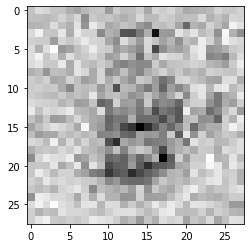

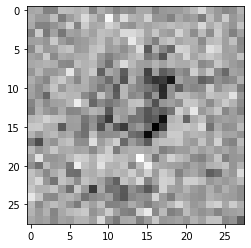

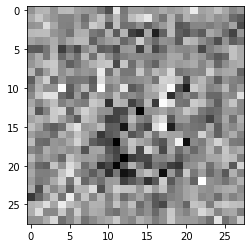

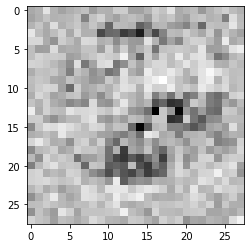

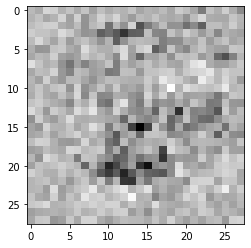

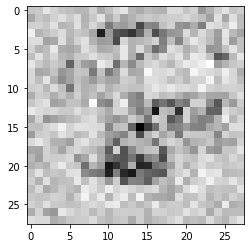

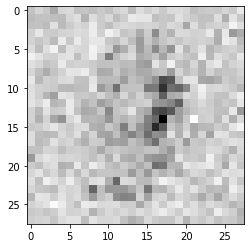

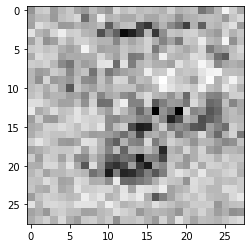

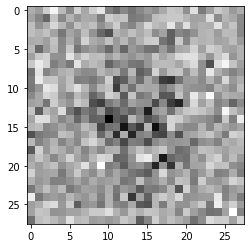

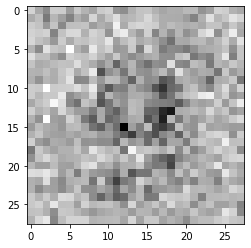

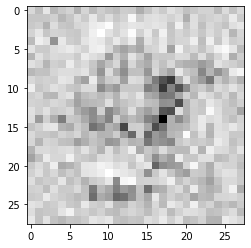

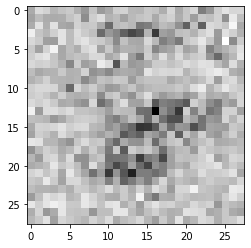

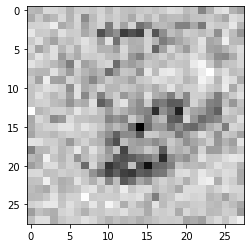

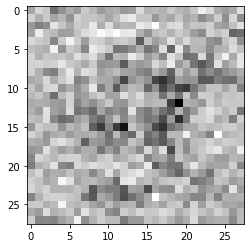

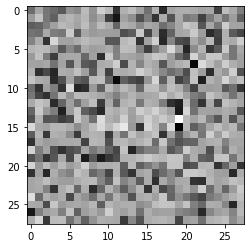

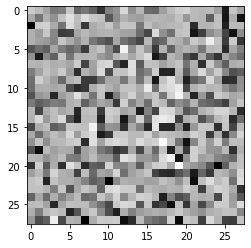

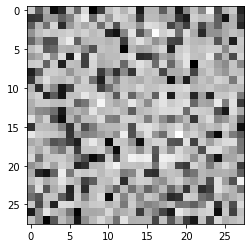

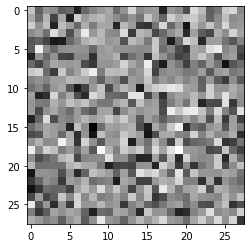

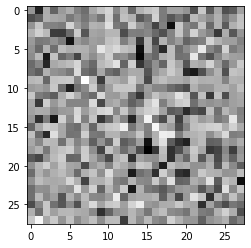

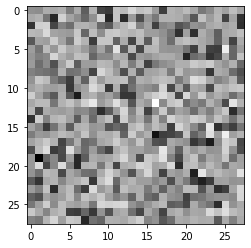

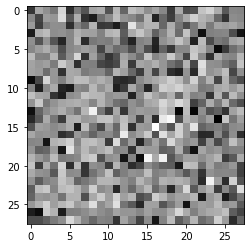

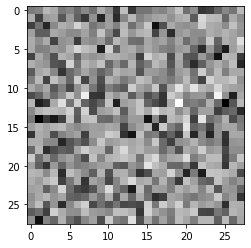

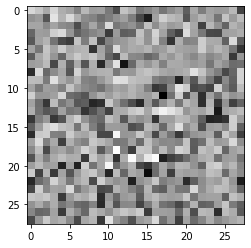

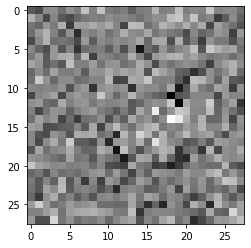

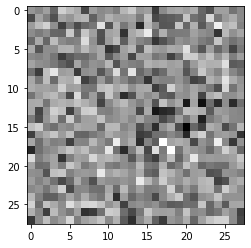

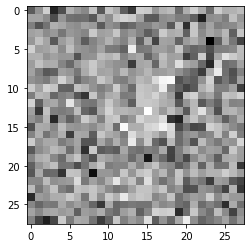

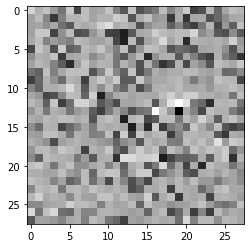

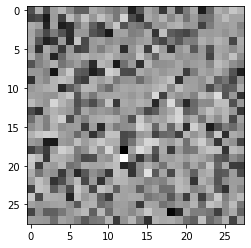

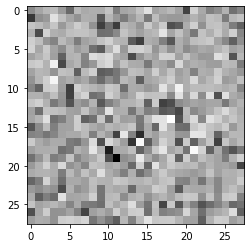

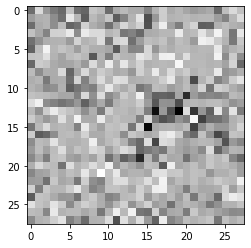

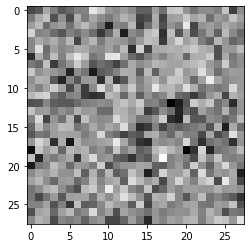

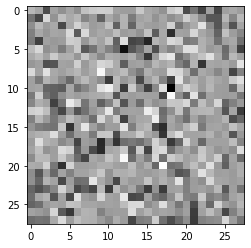

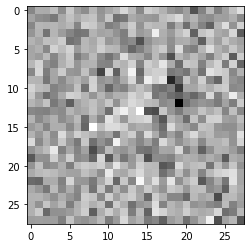

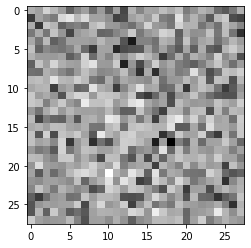

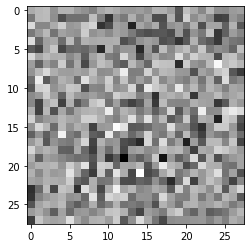

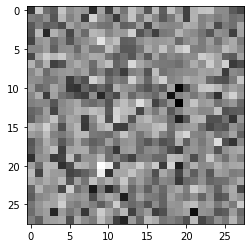

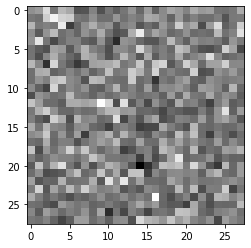

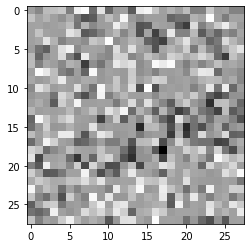

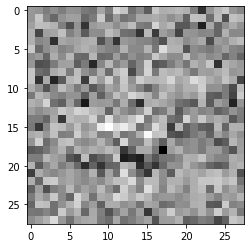

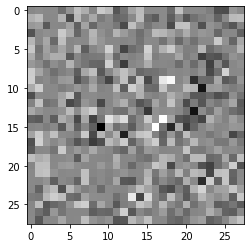

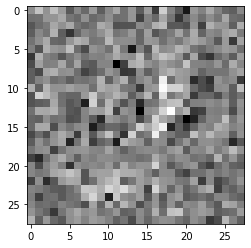

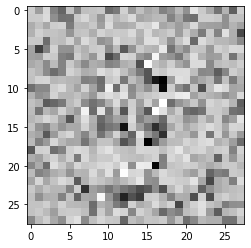

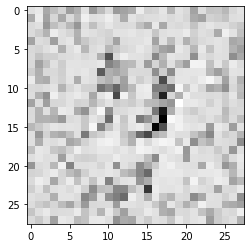

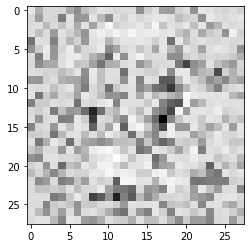

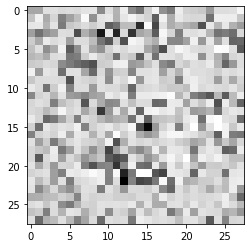

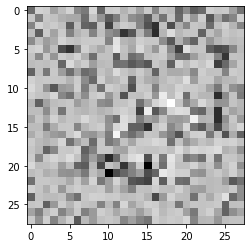

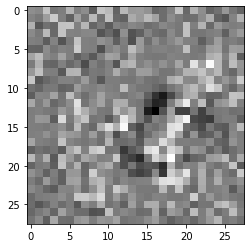

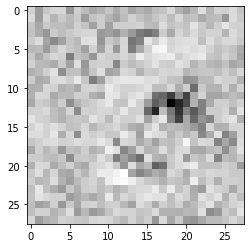

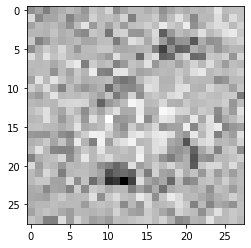

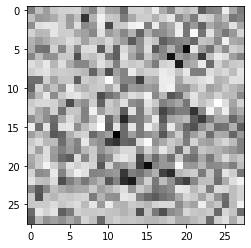

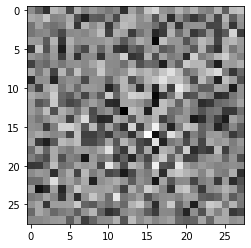

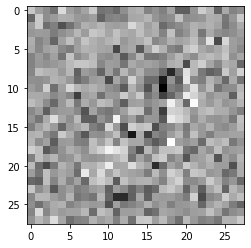

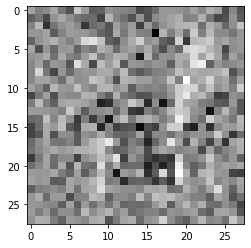

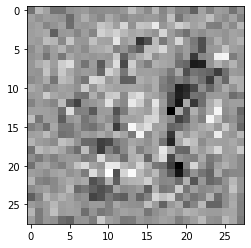

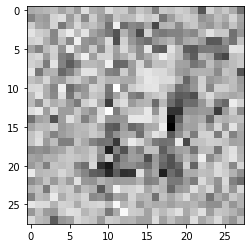

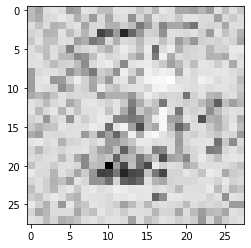

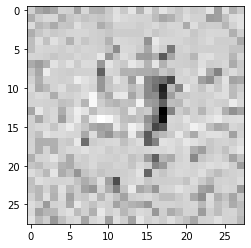

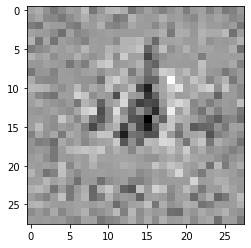

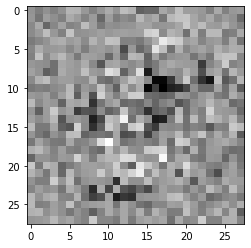

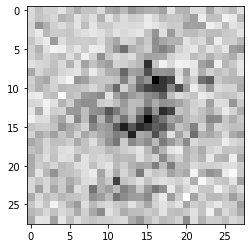

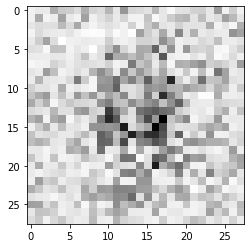

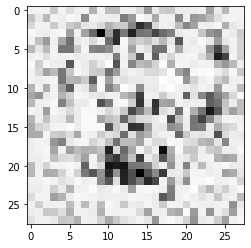

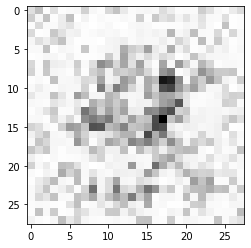

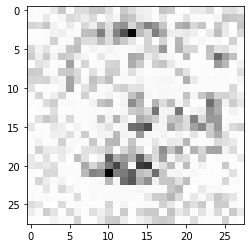

In [22]:
def saveEigenImages2():
    i=28*28-5
    while i <len(vbin.T):
        idx = i 
        if vbin.T[idx][:28*28].mean()<(vbin.T[idx][:28*28].max()+vbin.T[idx][:28*28].min())/2:
            vbin.T[idx]=-vbin.T[idx]
        img = vbin.T[idx][:28*28].to('cpu')
        pixels = img.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.savefig('lapInputLayerBin' + "/eigenVec%02d.png" % idx)
        plt.show()

        i +=1 

saveEigenImages2()

In [18]:
#Plotting eigenvectors 
idx = 815
print(ubin[idx])
img = vbin.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
print(-vbin.T[idx][-10:])
(-vbin.T[idx][-10:]).argmax()



    

NameError: name 'ubin' is not defined

In [24]:
vbin.T[28*28+25][872]


tensor(0.0387, device='cuda:0')

# Getting to know the eigenvectors : metrics 

- sign 
- Total entropy 
- Argmax 
- value at argmax 
- spatial correlations on input 

In [25]:
def positivise(v):
    """Transforme le signe de chaque colonne de la matrice v de sorte à ce que l'argmax soit de signe positif """
    res = torch.zeros(v.shape)
    for idx in range(len(v.T)):
        res[:,idx]=torch.sign(v.T[idx][torch.abs(v.T[idx]).argmax()])*v.T[idx]
    return res 
        
def sign(vec):
    """Détermine la fraction de signes - pour un vecteur propre vec"""
    return (torch.relu(-torch.sign(vec)).sum())/len(vec)

def maxValue(vec):
    return vec.max()

def argMax(vec):
    return vec.argmax()

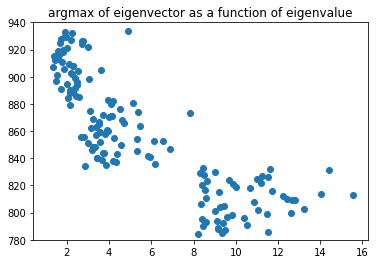

In [27]:
vbin = positivise(vbin)
vbin=vbin.to('cpu')
ubin = ubin.to('cpu')
plt.scatter(ubin[28*28:],[argMax(vec) for vec in vbin.T[28*28:]])
plt.title('argmax of eigenvector as a function of eigenvalue')
plt.ylim(780,940)
plt.show()

Text(0.5, 1.0, 'maximum value of eigenvector as a function of eigenvalue')

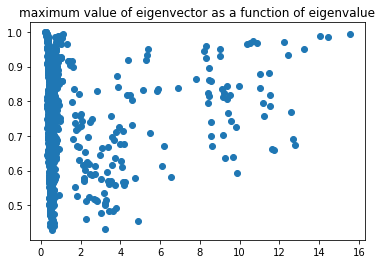

In [28]:
plt.scatter(ubin,[maxValue(vec) for vec in vbin.T])
plt.title('maximum value of eigenvector as a function of eigenvalue')

# Attaques adversariales 

## Training the model 

In [111]:
def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

In [4]:
loss_fn

CrossEntropyLoss()

In [8]:
arch = [28*28, 50,50,50, 10]
optimizer = torch.optim.SGD
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 15


for i in range(epochs):
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    
    
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights,positivation='relu')
u,v = lapOp.diagonalize()


def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')


Epoch 1
-------------------------------
Epoch training loss: 1.232151 	Epoch training accuracy: 60.45%                                      0 ]                       
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 84.08%,                 Avg loss: 0.486168 

Epoch 1
-------------------------------
Epoch training loss: 0.374288 	Epoch training accuracy: 88.96%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.50%,                 Avg loss: 0.291445 

Epoch 1
-------------------------------
Epoch training loss: 0.265638 	Epoch training accuracy: 92.27%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 93.28%,                 Avg loss: 0.230658 

Epoch 1
-------------------------------
Epoch training loss: 0.205433 	Ep

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_utils/tensor.py:16: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  R = torch.cholesky(VTV, upper=True)  # (*BMV, nguess, nguess)
/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_impls/linalg/symeig.py:174: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion

In [13]:
#Change the type of laplacian used

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights,positivation='none')
u,v = lapOp.diagonalize()

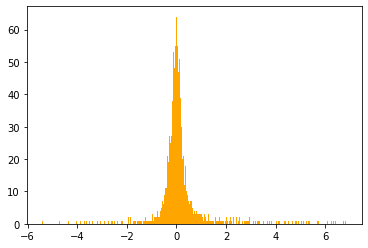

In [14]:
plt.hist(u.to('cpu').numpy(),bins=300,color='orange')
plt.show()


## Building the dataset

In [15]:
epsilon = 0.5
n_batch = 300 #Number of batch used to generate the dataset 
activ = torch.zeros((3,n_batch*32,len(u)))
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
    
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    label[k_batch*32:(k_batch+1)*32]=target
    
    k_batch+=1
    if k_batch>=n_batch:
        break 

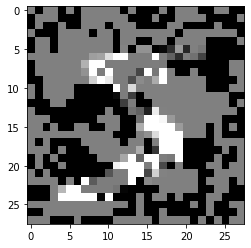

In [188]:
print28x28tensor(activ[1][0][:28*28])

In [189]:
(data[0].to('cpu')-activ[0][0][:28*28].reshape(1,28,28)).norm()

tensor(7.0225, grad_fn=<CopyBackwards>)

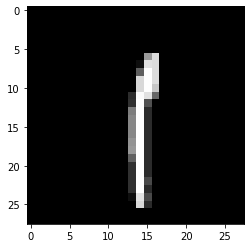

In [185]:
print28x28tensor(data[2].detach().reshape(784))

In [186]:
pipe.model(activ[0][2][:28*28].reshape(1,28,28).to(DEVICE)).argmax()

tensor(4, device='cuda:0')

In [187]:
model(data[1].to('cpu')).argmax()

tensor(5)

### Warning : this codes selects one specific class

In [256]:
idxs = label==0

activ=activ[:,idxs,:]

In [157]:
activ.shape

torch.Size([3, 34, 1094])

## Global statistics 

### Average per layer

In [28]:
activ.mean()

tensor(0.1637)

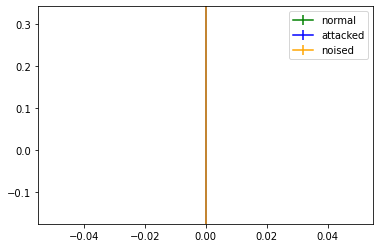

In [139]:
# Choix de l'index de l'input 
idx = 10

arch2 = arch[:-1]
avg = torch.zeros(3,len(arch2))
std = torch.zeros(3,len(arch2))
# Moyenne sur tous les neurones d'une même couche 

for alter in range(3):
    currentNode = 0
    for i,layerSize in enumerate(arch2):
        avg[alter][i] = activ[alter,idx,currentNode:(currentNode+layerSize)].mean()
        std[alter][i] = activ[alter,idx,currentNode:(currentNode+layerSize)].std()
        currentNode=currentNode+layerSize


plt.errorbar(range(len(arch2)),avg[0],yerr=std[0],color='green',label='normal')
plt.errorbar(range(len(arch2)),avg[1],yerr=std[1],color='blue',label='attacked')
plt.errorbar(range(len(arch2)),avg[2],yerr=std[2],color='orange',label='noised')
plt.legend()
plt.show()

In [29]:
activ[0][0][-10:]

tensor([10.2611, -8.6162,  2.5552, -4.8087,  3.2354,  0.3903,  4.1347,  1.4604,
        -3.1851, -3.4657])

### PCA

In [192]:
torch.cat([activ[0],activ[1]]).shape

torch.Size([84, 1094])

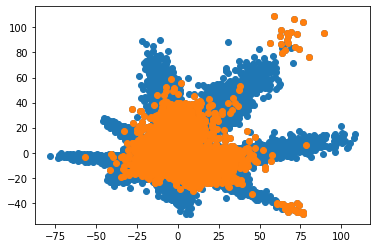

In [140]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X= pca.fit_transform(torch.cat([activ[0],activ[1]]))
Xattacked=pca.transform(activ[1])
Xnoised=pca.transform(activ[2])
plt.scatter(X[:,0],X[:,1])
plt.scatter(Xattacked[:,0],Xattacked[:,1])
#plt.scatter(Xnoised[:,0],Xnoised[:,1])

In [190]:
print(np.dot((activ[1].numpy()-pca.mean_),pca.components_[0].T))
print(Xattacked[:,0])

[ 5.79330473 -6.10584213 15.49898447 ... -1.39083518 -2.68015811
  7.5031791 ]
[ 5.79330473 -6.10584213 15.49898447 ... -1.39083518 -2.68015811
  7.5031791 ]


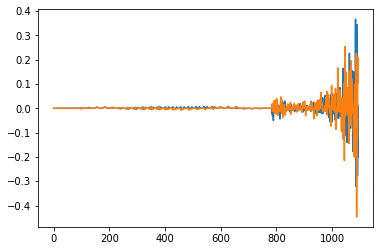

In [11]:
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])

#print(activ[0].numpy()@pca.components_[0].mean(),activ[0].numpy()@pca.components_[0].mean())

- Interpretation : nothing surprising, the PCA uses the last part of the activation to distinguish number classes which explains why adversarial examples fall in the middle. 
- When trained on one class only, the second pca component listens to intermediate neurons

### Laplacian statistics

In [190]:
# change basis to laplacian eigenvectors 
activL = torch.zeros((3,activ.shape[1],len(u))).to(DEVICE)
activ= activ.to(DEVICE)
for alter in range(3):
    activL[alter]=activ[alter]@v
activL=activL.to('cpu')

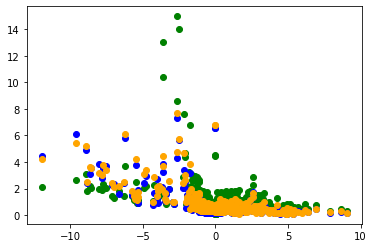

In [191]:
#Mean activation over each laplacian eigenvector in order 
u = u.to('cpu')
plt.scatter(u,torch.abs(activL[0]).mean(dim=0),color='green')
plt.scatter(u,torch.abs(activL[1]).mean(dim=0),color='blue')
plt.scatter(u,torch.abs(activL[2]).mean(dim=0),color='orange')

In [143]:
print("Activation normale moyenne : ",torch.abs(activ[0]).mean(dim=1).mean().item(), "std :" , torch.abs(activ[0]).mean(dim=1).std().item() )
print("Activation adversariale moyenne :", torch.abs(activ[1]).mean(dim=1).mean().item(), "std :" , torch.abs(activ[1]).mean(dim=1).std().item() )


Activation normale moyenne :  1.4616750478744507 std : 0.5236676335334778
Activation adversariale moyenne : 0.67737877368927 std : 0.35987380146980286


- Interpretation : The L1 norm of the activation is not sufficient for statistical detection of fgsm attacks (significant overlap of uncertainty zones)

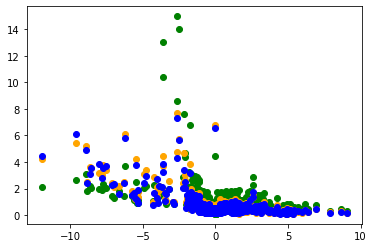

In [192]:
#Without the 0 eigenvalue
plt.scatter(u[1:],torch.abs(activL[0]).mean(dim=0)[1:],color='green')
plt.scatter(u[1:],torch.abs(activL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],torch.abs(activL[1]).mean(dim=0)[1:],color='blue')

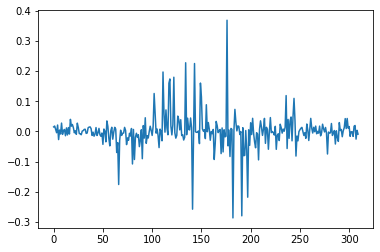

In [177]:
v=v.to('cpu')
plt.plot(v.T[-5])

In [196]:
u[1]

tensor(-12.8515)

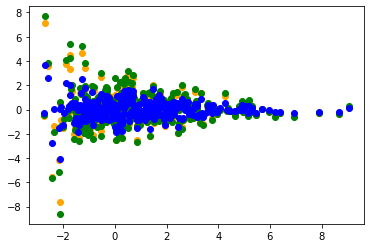

In [154]:
#Without the 0 eigenvalue, no absolute value 





plt.scatter(u[1:],(activL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],(activL[0]).mean(dim=0)[1:],color='green')
plt.scatter(u[1:],(activL[1]).mean(dim=0)[1:],color='blue')



tensor(44)
tensor(-2.1730)


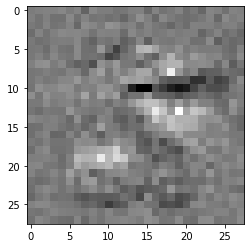

In [18]:
idx = (activL[0].mean(dim=0)).argmin()
print(idx)
print(u[idx])
print28x28tensor(v.T[idx][:28*28])

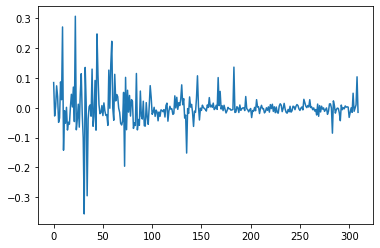

In [155]:
plt.plot(v.T[idx].to('cpu'))

The advserial activation seems to be lower, maybe this an overall scalar effect. We will try to correct it using the factor induced by the 0 eigenvalue ratio

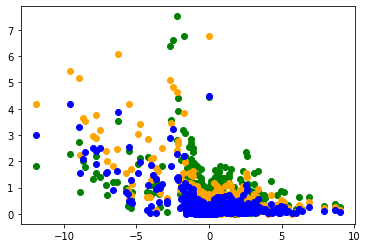

In [193]:
avgNormal = torch.abs((activL[0]).mean(dim=0))
avgPerturbed = torch.abs((activL[1]).mean(dim=0))
avgNoised = torch.abs((activL[2]).mean(dim=0))

plt.scatter(u[1:],avgNormal[1:],color='green')
plt.scatter(u[1:],avgNoised[1:],color='orange')
plt.scatter(u[1:],avgNormal[0]/avgPerturbed[0]*avgPerturbed[1:],color='blue')


In [194]:
print('L1 sum ratio',avgNormal[0]/avgPerturbed[0])
print(' cheeger coeff ratio', avgNormal[1]/avgPerturbed[1])
print('second eigenvector proj ratio', avgNormal[2]/avgPerturbed[2])
print('custom idx ratio',idx,avgNormal[idx]/avgPerturbed[idx])
print('overall norm ratio', avgNormal.norm()/avgPerturbed.norm())

L1 sum ratio tensor(0.6837)
 cheeger coeff ratio tensor(0.4178)
second eigenvector proj ratio tensor(0.3724)
custom idx ratio 40 tensor(1.5150)
overall norm ratio tensor(1.1557)


tensor(-2.6748)


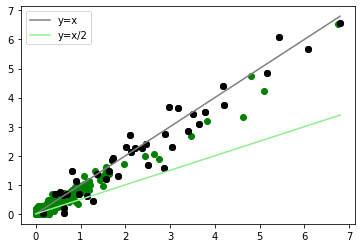

In [195]:
#scatter plot of the same thing 
idx = 40
plt.scatter(avgNoised[idx:],avgPerturbed[idx:],color='green')
plt.scatter(avgNoised[:idx],avgPerturbed[:idx],color='black')
plt.scatter(avgNoised[:idx],avgPerturbed[:idx],color='black')
#plt.scatter(avgNoised,avgNormal,color='orange')
x = np.arange(avgNoised.min(),avgNoised.max(),step=1/100)
plt.plot(x,x,label='y=x',color='grey')
plt.plot(x,x/2,label='y=x/2',color='lightgreen')
plt.legend()
print(u[idx])

In [159]:
print(avgNoised[33])
avgPerturbed[33]

tensor(1.4366)


tensor(1.3381)

Some eigenprojections get halved (above a certain threshold) 

Layer : tensor(-15.6800)
Layer : tensor(-15.0600)
Layer : tensor(-9.6000)
Layer : tensor(-15.0600)
Layer : tensor(-15.)
Layer : tensor(-15.)
Layer : tensor(-12.3400)
Layer : tensor(-9.5200)
Layer : tensor(-9.8600)
Layer : tensor(-12.3400)
Layer : tensor(-15.0600)
Layer : tensor(-12.9800)
Layer : tensor(-12.7800)
Layer : tensor(-15.0400)
Layer : tensor(-15.4800)
Layer : tensor(-12.7800)
Layer : tensor(-13.0800)
Layer : tensor(-15.5000)
Layer : tensor(-15.5000)
Layer : tensor(-12.0200)
Layer : tensor(-11.3600)
Layer : tensor(-14.2800)
Layer : tensor(-14.8000)
Layer : tensor(-11.5600)
Layer : tensor(-13.0800)
Layer : tensor(-11.0400)
Layer : tensor(-13.2800)
Layer : tensor(-15.6200)
Layer : tensor(-13.3600)
Layer : tensor(-14.2800)
Layer : tensor(-11.6600)
Layer : tensor(-15.4800)
Layer : tensor(-11.3600)
Layer : tensor(-15.1400)
Layer : tensor(-10.3200)
Layer : tensor(-9.6000)
Layer : tensor(-12.3200)
Layer : tensor(-15.4800)


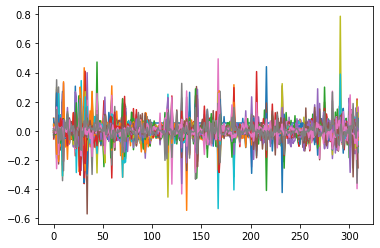

In [160]:
v=v.to('cpu')
for i in range(38):
    plt.plot(v.T[i])
    print('Layer :',(torch.abs(v.T[i]).argmax()-28*28)/50)

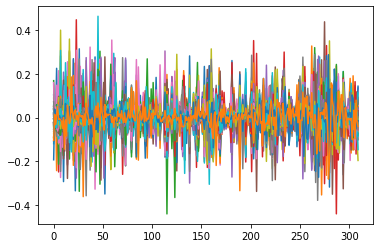

In [161]:
v=v.to('cpu')
for i in range(38,100):
    plt.plot(v.T[i])

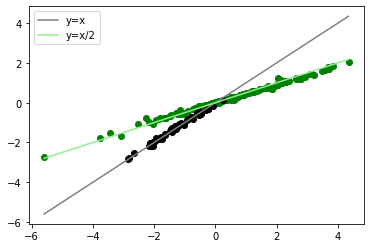

In [163]:
idx = 50 #28*28+50
activ = activ.to('cpu')
plt.scatter(activ[2].mean(dim=0)[idx:],activ[1].mean(dim=0)[idx:],color='green')
plt.scatter(activ[2].mean(dim=0)[:idx],activ[1].mean(dim=0)[:idx],color='black')
x = np.arange(activ[2].mean(dim=0).min(),activ[2].mean(dim=0).max(),step=1/100)
plt.plot(x,x,label='y=x',color='grey')
plt.plot(x,x/2,label='y=x/2',color='lightgreen')
plt.legend()



tensor(-12.8515)


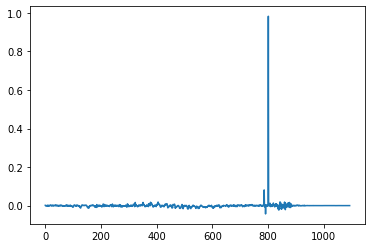

In [213]:
plt.plot(v.T[1].to('cpu')) # Cheeger vector 
print(u[1])

tensor(-11.9366)


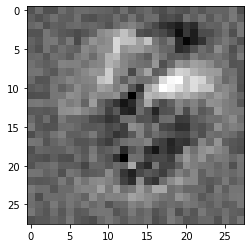

In [28]:
print28x28tensor(v.T[1][:28*28])
print(u[1])

In [215]:
fiedlerInput = v.T[1][:28*28].reshape(1,28,28)


In [9]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): FFNet(
    (linears): ModuleList(
      (0): Linear(in_features=784, out_features=50, bias=False)
      (1): Linear(in_features=50, out_features=50, bias=False)
      (2): Linear(in_features=50, out_features=50, bias=False)
      (3): Linear(in_features=50, out_features=50, bias=False)
      (4): Linear(in_features=50, out_features=50, bias=False)
      (5): Linear(in_features=50, out_features=50, bias=False)
      (6): Linear(in_features=50, out_features=10, bias=False)
    )
  )
)

In [153]:
me.get_activations(-fiedlerInput)

[tensor([[-0.0218, -0.0186, -0.0189, -0.0193, -0.0197, -0.0201, -0.0211, -0.0187,
          -0.0193, -0.0183, -0.0196, -0.0195, -0.0182, -0.0207, -0.0176, -0.0186,
          -0.0183, -0.0179, -0.0191, -0.0206, -0.0202, -0.0185, -0.0179, -0.0238,
          -0.0181, -0.0178, -0.0196, -0.0218, -0.0171, -0.0181, -0.0204, -0.0196,
          -0.0174, -0.0196, -0.0192, -0.0191, -0.0191, -0.0206, -0.0207, -0.0226,
          -0.0184, -0.0178, -0.0188, -0.0167, -0.0172, -0.0193, -0.0200, -0.0189,
          -0.0211, -0.0196, -0.0183, -0.0182, -0.0184, -0.0180, -0.0213, -0.0189,
          -0.0199, -0.0201, -0.0215, -0.0201, -0.0192, -0.0187, -0.0209, -0.0203,
          -0.0206, -0.0200, -0.0166, -0.0198, -0.0179, -0.0170, -0.0193, -0.0172,
          -0.0181, -0.0182, -0.0183, -0.0180, -0.0232, -0.0188, -0.0176, -0.0211,
          -0.0202, -0.0197, -0.0195, -0.0195, -0.0198, -0.0181, -0.0187, -0.0189,
          -0.0178, -0.0204, -0.0210, -0.0190, -0.0175, -0.0163, -0.0157, -0.0144,
          -0.014

### Cheeger projection analysis 
We investigate wether the projection on the Fiedler vector discriminates statistically attacks from normal observations

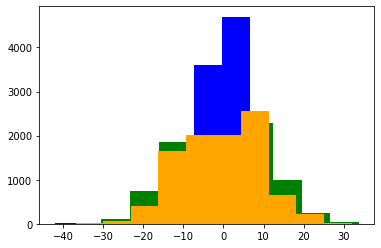

In [164]:
idx = 1

cheegerCoeffNormal = activL[0,:,idx].reshape(1,activL.shape[1])
cheegerCoeffPerturbed = activL[1,:,idx].reshape(1,activL.shape[1])
cheegerCoeffNoised = activL[2,:,idx].reshape(1,activL.shape[1])
plt.hist(cheegerCoeffNormal,facecolor='g')
plt.hist(cheegerCoeffPerturbed,facecolor='b')
plt.hist(cheegerCoeffNoised,facecolor='orange')
plt.show()

### Cumulative spectrum distribution analysis

In [222]:
(u-torch.tensor(sorted(u))).norm()

tensor(13.1437)

In [223]:
avgNormal.shape

torch.Size([1094])

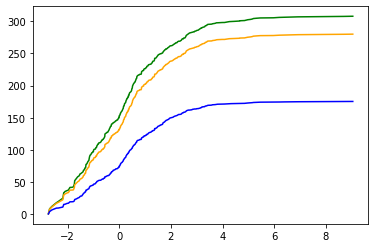

In [166]:
csNormal = torch.cumsum(avgNormal[1:],0)
csPerturbed = torch.cumsum(avgPerturbed[1:],0)
csNoised = torch.cumsum(avgNoised[1:],0)

plt.plot(u[1:],csNormal,color='green')
plt.plot(u[1:],csNoised,color='orange')
plt.plot(u[1:],csPerturbed,color='blue')
plt.show()

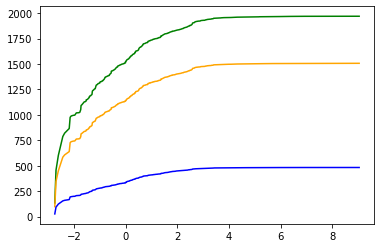

In [167]:
# Looking at the second moment 
avgNormal2 = torch.abs((activL[0]**2).mean(dim=0))
avgPerturbed2 = torch.abs((activL[1]**2).mean(dim=0))
avgNoised2 = torch.abs((activL[2]**2).mean(dim=0))

csNormal2 = torch.cumsum(avgNormal2[1:],0)
csPerturbed2 = torch.cumsum(avgPerturbed2[1:],0)
csNoised2 = torch.cumsum(avgNoised2[1:],0)

plt.plot(u[1:],csNormal2,color='green')
plt.plot(u[1:],csNoised2,color='orange')
plt.plot(u[1:],csPerturbed2,color='blue')
plt.show()



# Adversarial attacks gradient spectral analysis

<span style="color:red">WARNING : Adding bias to model to compute loss gradient per neuron </span>.
### Building the gradient dataset

In [168]:
arch = [28*28, 50, 50, 50,50,50,50, 10]
optimizer = torch.optim.SGD
model2 = nn.Sequential(nn.Flatten(), FFNet(arch,bias=True )).to(DEVICE)
pipe2 = Pipeline(model2, (dl_tr, dl_ts), loss_fn, writer)

state_dict = pipe.model.state_dict()
state_dict2 = pipe2.model.state_dict()
for i in range(len(arch)-1):
    name = '1.linears.'+str(i)+'.weight'
    state_dict2[name]=state_dict[name]
    nameBias = '1.linears.'+str(i)+'.bias'
    state_dict2[nameBias]=torch.zeros(state_dict2[nameBias].shape).to(DEVICE)
pipe2.model.load_state_dict(state_dict2)


me2 = ModelExtractor(pipe2.model, pipe2.loss_fn)

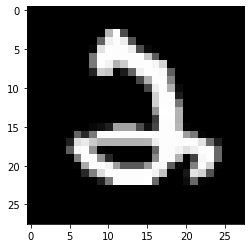

In [37]:
print28x28tensor(data[1][:28*28].detach())

In [38]:
me2.model(data[1][:28*28]).argmax()

tensor(2, device='cuda:0')

In [204]:
epsilon = 0.5
n_batch = 10 #Number of batch used to generate the dataset 
activG = torch.zeros((3,n_batch*32,len(u))) #Gradient activation
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)
predLabel = torch.zeros(3,n_batch*32)


def get_grad_activ(x,mextractor):
    """ Returns the gradient vector (one coefficient for each neuron )
    """
    with torch.no_grad():
        target = mextractor.model(x).argmax(dim=1)
    mextractor.model.zero_grad()
    grads = mextractor.get_gradients(x,target=target)
    return torch.cat([grads[0].reshape(784),torch.cat(grads[1][1::2])])


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
        
        
        with torch.no_grad():
            predLabel[0][k_batch*32+i] = me.model(data[i]).argmax().item()
            predLabel[1][k_batch*32+i] = me.model(data_perturbed[i]).argmax().item()
            predLabel[2][k_batch*32+i] = me.model(data_noised[i]).argmax().item()
        
        activG[0][k_batch+i]=get_grad_activ(torch.autograd.Variable(data[i]),me2)
        activG[1][k_batch+i]=get_grad_activ(torch.autograd.Variable(data_perturbed[i]),me2)
        activG[2][k_batch+i]=get_grad_activ(torch.autograd.Variable(data_noised[i]),me2)
        
        
        
        
    
    #normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    #perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    #noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    #activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    #activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    #activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    label[k_batch*32:(k_batch+1)*32]=target
    
    k_batch+=1
    if k_batch>=n_batch:
        break 

In [40]:
print("Correct model prediction(%) : ")
print(100*((predLabel[0]==label).sum()/len(label)).item())
print("Correct model prediction under attack (%) : ")
print(100*((predLabel[1]==label).sum()/len(label)).item())
print("Correct model prediction with noise (%) : ")
print(100*((predLabel[2]==label).sum()/len(label)).item())

Correct model prediction(%) : 
96.875
Correct model prediction under attack (%) : 
43.437498807907104
Correct model prediction with noise (%) : 
95.3125


In [41]:
idx = 0
model(data[0][idx][:28*28].reshape(1,28,28).to('cpu'))

tensor([[-0.0001, -0.0002,  0.0003,  0.0003, -0.0010,  0.0002,  0.0002,  0.0003,
          0.0002,  0.0003]], grad_fn=<MmBackward0>)

### Gradient statistics

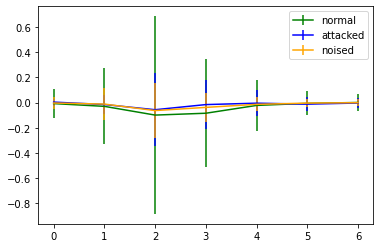

Correct label :  2.0
 Predicted label :  2.0
 Attacked label :  8.0
 Noised label :  2.0


In [202]:
# Choix de l'index de l'input 
idx = 5

arch2 = arch[:-1]
avg = torch.zeros(3,len(arch2))
std = torch.zeros(3,len(arch2))
# Moyenne sur tous les neurones d'une même couche 

for alter in range(3):
    currentNode = 0
    for i,layerSize in enumerate(arch2):
        avg[alter][i] = activG[alter,idx,currentNode:(currentNode+layerSize)].mean()
        std[alter][i] = activG[alter,idx,currentNode:(currentNode+layerSize)].std()
        currentNode=currentNode+layerSize


plt.errorbar(range(len(arch2)),avg[0],yerr=std[0],color='green',label='normal')
plt.errorbar(range(len(arch2)),avg[1],yerr=std[1],color='blue',label='attacked')
plt.errorbar(range(len(arch2)),avg[2],yerr=std[2],color='orange',label='noised')
plt.legend()
plt.show()

print('Correct label : ',label[idx].item())
print(' Predicted label : ', predLabel[0][idx].item())
print(' Attacked label : ', predLabel[1][idx].item())
print(' Noised label : ', predLabel[2][idx].item() )


In [35]:
avg[1]

tensor([ 0.0005, -0.0019, -0.0076, -0.0046, -0.0019, -0.0010, -0.0003])

In [33]:
activG.shape

torch.Size([3, 320, 1094])

In [32]:
activG[0][0][-10:]

tensor([ 1.4613e-10,  5.9775e-18,  4.4139e-14,  6.9823e-04,  5.6042e-11,
        -1.3921e-03,  7.2995e-14,  1.5735e-16,  4.4847e-06,  6.8939e-04])


### PCA

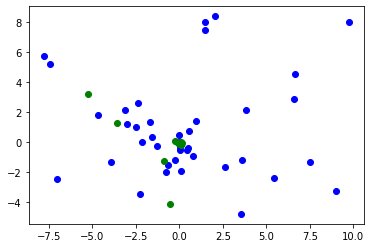

In [43]:


import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(torch.cat([activG[0],activG[1]]))
X = pca.transform(activG[0])
Xattacked=pca.transform(activG[1])
Xnoised=pca.transform(activG[2])
plt.scatter(Xattacked[:,0],Xattacked[:,1],color='blue')
plt.scatter(X[:,0],X[:,1],color='green')
#plt.scatter(Xnoised[:,0],Xnoised[:,1])

In [44]:

print(np.dot((activG[1].numpy()-pca.mean_),pca.components_[0].T))
print(Xattacked[:,0])

[-6.49175376e-03  3.54073387e+00  6.58867076e+00  3.84662801e+00
 -2.38508480e+00 -7.37860367e-01  4.76748163e-01  4.17582881e-01
 -2.16095422e+00  5.32956333e-01  9.01578902e+00  9.72441768e+00
 -2.47344727e+00 -2.27033843e+00 -3.02746537e+00 -7.83914566e-03
 -1.70581625e+00 -4.66152404e+00  2.60120203e+00 -3.90682221e+00
  8.05070235e-01  7.49432634e+00  2.04521163e+00 -2.27184661e-01
  2.40698944e-02  9.88353910e-01  1.46465350e+00  8.07391505e-02
  1.47682816e+00  3.73535828e-02  3.59052521e+00 -3.10808511e+00
 -6.53481854e-01  5.42644893e+00 -3.48317630e-02 -7.03391487e+00
 -1.54586020e+00 -1.26997407e+00 -7.76079178e+00  6.66112595e+00
 -7.45171459e+00 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03
 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03
 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03
 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03
 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03 -7.27343081e-03
 -7.27343081e-03 -7.27343

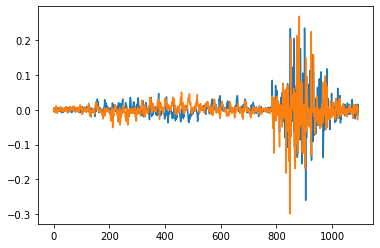

In [45]:


plt.plot(pca.components_[0])
plt.plot(pca.components_[1])

#print(activ[0].numpy()@pca.components_[0].mean(),activ[0].numpy()@pca.components_[0].mean())


- Interpretation :TODO


### Laplacian statistics

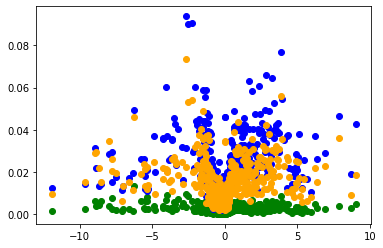

In [205]:


# change basis to laplacian eigenvectors 
activGL = torch.zeros((3,activG.shape[1],len(u))).to(DEVICE)
activG= activG.to(DEVICE)
v=v.to(DEVICE)
for alter in range(3):
    activGL[alter]=activG[alter]@v

activGL=activGL.to('cpu')

#Mean activation over each laplacian eigenvector in order 
u = u.to('cpu')
plt.scatter(u,torch.abs(activGL[0]).mean(dim=0),color='green')
plt.scatter(u,torch.abs(activGL[1]).mean(dim=0),color='blue')
plt.scatter(u,torch.abs(activGL[2]).mean(dim=0),color='orange')

In [47]:
print("Activation normale moyenne : ",torch.abs(activG[0]).mean(dim=1).mean().item(), "std :" , torch.abs(activG[0]).mean(dim=1).std().item() )
print("Activation adversariale moyenne :", torch.abs(activG[1]).mean(dim=1).mean().item(), "std :" , torch.abs(activG[1]).mean(dim=1).std().item() )

Activation normale moyenne :  0.0011641111923381686 std : 0.00975474901497364
Activation adversariale moyenne : 0.01054975762963295 std : 0.03566471487283707



- Interpretation : The L1 norm of the activation is not sufficient for statistical detection of fgsm attacks (significant overlap of uncertainty zones)


tensor(-11.9366)

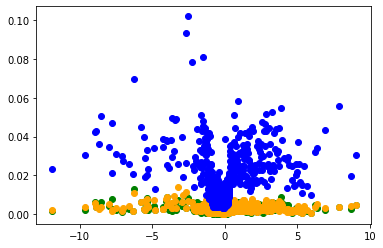

In [48]:

#Without the 0 eigenvalue
plt.scatter(u[1:],torch.abs(activGL[0]).mean(dim=0)[1:],color='green')
plt.scatter(u[1:],torch.abs(activGL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],torch.abs(activGL[1]).mean(dim=0)[1:],color='blue')

u[1]


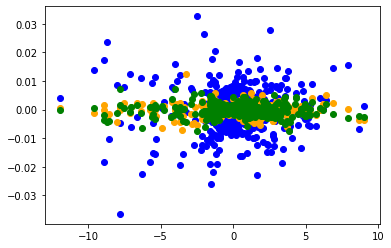

In [49]:

#Without the 0 eigenvalue, no absolute value 


plt.scatter(u[1:],(activGL[1]).mean(dim=0)[1:],color='blue')
plt.scatter(u[1:],(activGL[2]).mean(dim=0)[1:],color='orange')
plt.scatter(u[1:],(activGL[0]).mean(dim=0)[1:],color='green')


L1 sum ratio tensor(1.5176)
 cheeger coeff ratio tensor(0.0062)
second eigenvector proj ratio tensor(0.0374)
overall norm ratio tensor(0.2317)


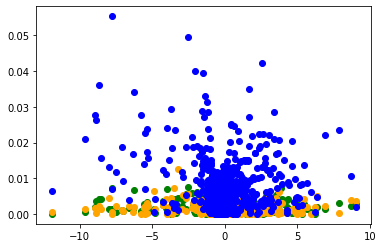

In [50]:




avgNormal = torch.abs((activGL[0]).mean(dim=0))
avgPerturbed = torch.abs((activGL[1]).mean(dim=0))
avgNoised = torch.abs((activGL[2]).mean(dim=0))

plt.scatter(u[1:],avgNormal[1:],color='green')
plt.scatter(u[1:],avgNoised[1:],color='orange')
plt.scatter(u[1:],avgNormal[0]/avgPerturbed[0]*avgPerturbed[1:],color='blue')


print('L1 sum ratio',avgNormal[0]/avgPerturbed[0])
print(' cheeger coeff ratio', avgNormal[1]/avgPerturbed[1])
print('second eigenvector proj ratio', avgNormal[2]/avgPerturbed[2])
print('overall norm ratio', avgNormal.norm()/avgPerturbed.norm())

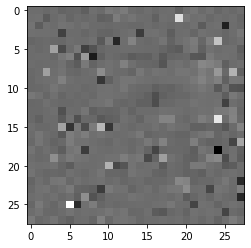

In [52]:
print28x28tensor(v.T[idx][:28*28])

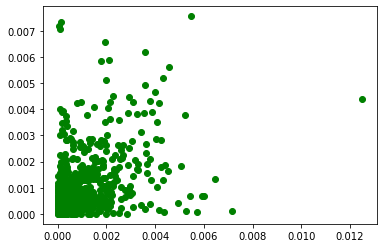

In [57]:
#scatter plot of the same thing 
plt.scatter(avgNoised[1:],avgNormal[1:],color='green')

## Logistic regression 

In [196]:
from sklearn.model_selection import train_test_split 
from tqdm import tqdm 
import numpy as np 

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)     
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    def train(self,optimizer,criterion,epochs,X_train,X_test,y_train,y_test):
        losses = []
        losses_test = []
        Iterations = []
        iter = 0
        for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
            x = X_train
            labels = y_train
            optimizer.zero_grad() # Setting our stored gradients equal to zero
            outputs = self(X_train)
            loss = criterion(torch.squeeze(outputs), labels) 

            loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

            optimizer.step() # Updates weights and biases with the optimizer (SGD)

            iter+=1
            if iter%1000==0:
                with torch.no_grad():
                    # Calculating the loss and accuracy for the test dataset
                    correct_test = 0
                    total_test = 0
                    outputs_test = torch.squeeze(self(X_test))
                    loss_test = criterion(outputs_test, y_test)

                    predicted_test = outputs_test.round().detach().numpy()
                    total_test += y_test.size(0)
                    correct_test += np.sum(predicted_test == y_test.detach().numpy())
                    accuracy_test = 100 * correct_test/total_test
                    losses_test.append(loss_test.item())

                    # Calculating the loss and accuracy for the train dataset
                    total = 0
                    correct = 0
                    total += y_train.size(0)
                    correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                    accuracy = 100 * correct/total
                    losses.append(loss.item())
                    Iterations.append(iter)

                    print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                    print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")



activ = activ.to('cpu')
                    
n_samples = len(activ[1])

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activ[2],activ[1]]), torch.cat([torch.zeros(n_samples),torch.ones(n_samples)]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 4000
input_dim = activ.shape[2] 
learning_rate = 0.01

model = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

Training Epochs:  26%|█████▍               | 1044/4000 [00:04<00:12, 232.05it/s]

Iteration: 1000. 
Test - Loss: 0.0459347628057003. Accuracy: 98.31123737373737
Train -  Loss: 0.02510056644678116. Accuracy: 99.44029850746269



Training Epochs:  51%|██████████▋          | 2028/4000 [00:08<00:08, 231.12it/s]

Iteration: 2000. 
Test - Loss: 0.05251823738217354. Accuracy: 98.23232323232324
Train -  Loss: 0.015439504757523537. Accuracy: 99.72792288557214



Training Epochs:  76%|███████████████▉     | 3035/4000 [00:13<00:04, 230.35it/s]

Iteration: 3000. 
Test - Loss: 0.06467781960964203. Accuracy: 98.02714646464646
Train -  Loss: 0.010274671018123627. Accuracy: 99.86784825870647



Training Epochs: 100%|█████████████████████| 4000/4000 [00:17<00:00, 230.69it/s]

Iteration: 4000. 
Test - Loss: 0.08080971986055374. Accuracy: 97.85353535353535
Train -  Loss: 0.006692181807011366. Accuracy: 99.94558457711443



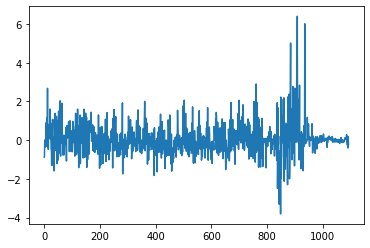

In [201]:
plt.plot(model.linear.weight.detach().to('cpu').T)

In [170]:
# Testing the efficiency for attack detection of the Fiedler vector using a learnable bias 

epochs = 2000
input_dim = activL.shape[2] 
learning_rate = 0.01

model_fiedler = LogisticRegression(input_dim)

v=v.to('cpu')
idx = 1 #1 for fiedler vector 
with torch.no_grad():
    # Initialize using previous model : 
    model_fiedler.linear.weight = nn.Parameter(-v[:,idx].reshape(1,input_dim))
    model_fiedler.linear.bias = nn.Parameter(torch.zeros(1))

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([model_fiedler.linear.bias], lr=learning_rate)
 

    
model_fiedler.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)


Training Epochs:  55%|███████████▌         | 1106/2000 [00:01<00:01, 734.74it/s]

Iteration: 1000. 
Test - Loss: 4.97316837310791. Accuracy: 52.02020202020202
Train -  Loss: 5.176304817199707. Accuracy: 51.702425373134325



Training Epochs: 100%|█████████████████████| 2000/2000 [00:02<00:00, 722.40it/s]

Iteration: 2000. 
Test - Loss: 4.97316837310791. Accuracy: 52.02020202020202
Train -  Loss: 5.176304817199707. Accuracy: 51.702425373134325



torch.Size([1])


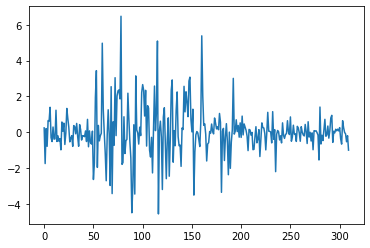

In [171]:
print((model.linear.bias).shape)
plt.plot((model.linear.weight[0,:].detach()))
plt.show()


There seems to be a dominating frequency, this is due to the regular spatial structure of the input.

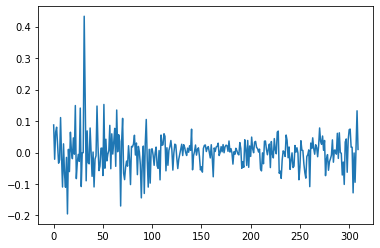

In [172]:
v=v.to('cpu')
plt.plot(v.T[1])

In [173]:
# Testing a simplified version of the Fiedler vector 
# Testing the efficiency for attack detection of the Fiedler vector using a learnable bias 

epochs = 2000
input_dim = activL.shape[2] 
learning_rate = 0.01

model_fiedler = LogisticRegression(input_dim)

with torch.no_grad():
    # Initialize using previous model : 
    weight = -v[:,1].reshape(1,input_dim).clone()
    weight[0,0:784]=0.02*torch.ones(784)
    model_fiedler.linear.weight = nn.Parameter(weight)
    model_fiedler.linear.bias = nn.Parameter(torch.zeros(1))

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD([model_fiedler.linear.bias], lr=learning_rate)
 

    
model_fiedler.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)


RuntimeError: The expanded size of the tensor (310) must match the existing size (784) at non-singleton dimension 0.  Target sizes: [310].  Tensor sizes: [784]

Performances do not degrade that much when removing input specific info 

In [142]:
len(v.T[1])

1094

In [146]:
# Testing a simplified version of the Fiedler vector 
# Testing the efficiency for attack detection of the Fiedler vector using a learnable bias 

epochs = 2000
input_dim = activL.shape[2] 
learning_rate = 0.01

model_fiedler = LogisticRegression(input_dim)

with torch.no_grad():
    # Initialize using previous model : 
    weight = torch.zeros(1,input_dim)
    weight[0,0:784]=0.02*torch.ones(784)
    weight[0,784:]=-0.08*torch.ones(input_dim-784)
    model_fiedler.linear.weight = nn.Parameter(weight)
    model_fiedler.linear.bias = nn.Parameter(torch.zeros(1))

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD([model_fiedler.linear.bias], lr=learning_rate)
 

    
model_fiedler.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)


Training Epochs:  51%|██████████▊          | 1029/2000 [00:04<00:04, 238.12it/s]

Iteration: 1000. 
Test - Loss: 1.292639970779419. Accuracy: 67.70833333333333
Train -  Loss: 1.2301771640777588. Accuracy: 67.04757462686567



Training Epochs: 100%|█████████████████████| 2000/2000 [00:08<00:00, 236.04it/s]

Iteration: 2000. 
Test - Loss: 1.2916803359985352. Accuracy: 67.6925505050505
Train -  Loss: 1.2279582023620605. Accuracy: 66.91542288557214



In [158]:
activSimple.shape

torch.Size([3, 2, 9600])

In [255]:
# Try to use only sum of input vs sum of hidden neurons 
n_samples = len(activ[1])

firstCoord = activ[:,:,:784].sum(dim=2).reshape(3,n_samples,1)
secondCoord = activ[:,:,784:].sum(dim=2).reshape(3,n_samples,1)
activSimple= torch.cat([firstCoord,secondCoord],dim=2)


X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activSimple[2],activSimple[1]]), torch.cat([torch.zeros(n_samples),torch.ones(n_samples)]), test_size=0.33, random_state=42)



X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 5000
input_dim = 2
learning_rate = 0.01

model_simple = LogisticRegression(input_dim)

with torch.no_grad():
    # Initialize using previous model : 
    model_simple.linear.weight = nn.Parameter(torch.tensor([0.02,-0.08]).reshape(1,2))
    model_simple.linear.bias = nn.Parameter(torch.zeros(1))




criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([model_simple.linear.bias,model_simple.linear.weight], lr=learning_rate)

model_simple.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

Training Epochs:  25%|█████               | 1264/5000 [00:00<00:02, 1854.91it/s]

Iteration: 1000. 
Test - Loss: 0.5250601768493652. Accuracy: 76.46780303030303
Train -  Loss: 0.4973198473453522. Accuracy: 77.41759950248756



Training Epochs:  44%|████████▊           | 2191/5000 [00:01<00:01, 1804.51it/s]

Iteration: 2000. 
Test - Loss: 0.5250641107559204. Accuracy: 76.48358585858585
Train -  Loss: 0.4973198175430298. Accuracy: 77.42537313432835



Training Epochs:  66%|█████████████▏      | 3295/5000 [00:01<00:00, 1827.96it/s]

Iteration: 3000. 
Test - Loss: 0.5250641107559204. Accuracy: 76.48358585858585
Train -  Loss: 0.4973198175430298. Accuracy: 77.42537313432835



Training Epochs:  85%|████████████████▉   | 4231/5000 [00:02<00:00, 1862.73it/s]

Iteration: 4000. 
Test - Loss: 0.5280450582504272. Accuracy: 76.89393939393939
Train -  Loss: 0.49987298250198364. Accuracy: 76.99782338308458



Training Epochs: 100%|████████████████████| 5000/5000 [00:02<00:00, 1824.86it/s]

Iteration: 5000. 
Test - Loss: 0.5250638723373413. Accuracy: 76.46780303030303
Train -  Loss: 0.49731987714767456. Accuracy: 77.42537313432835



In [256]:
model_simple.linear.weight

Parameter containing:
tensor([[-0.0009, -0.0447]], requires_grad=True)

### Change to laplacian basis 

In [174]:
n_samples = len(activL[1])

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activL[2],activL[1]]), torch.cat([torch.zeros(n_samples),torch.ones(n_samples)]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 20000
input_dim = activL.shape[2] 
learning_rate = 0.01

model2 = LogisticRegression(input_dim)
"""
with torch.no_grad():
    # Initialize using previous model : 
    model2.linear.weight = nn.Parameter(model.linear.weight.clone()@v.to('cpu'))
"""

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
 

    
model2.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

Training Epochs:   5%|█                   | 1093/20000 [00:01<00:26, 712.19it/s]

Iteration: 1000. 
Test - Loss: 0.3305644690990448. Accuracy: 87.95770202020202
Train -  Loss: 0.32285165786743164. Accuracy: 88.03638059701493



Training Epochs:  11%|██                  | 2124/20000 [00:02<00:24, 730.43it/s]

Iteration: 2000. 
Test - Loss: 0.3241522014141083. Accuracy: 87.97348484848484
Train -  Loss: 0.313876211643219. Accuracy: 88.42506218905473



Training Epochs:  15%|███                 | 3078/20000 [00:04<00:23, 722.85it/s]

Iteration: 3000. 
Test - Loss: 0.321970671415329. Accuracy: 88.3364898989899
Train -  Loss: 0.3112608790397644. Accuracy: 88.45615671641791



Training Epochs:  20%|████                | 4086/20000 [00:05<00:21, 725.52it/s]

Iteration: 4000. 
Test - Loss: 0.3186202347278595. Accuracy: 88.27335858585859
Train -  Loss: 0.30657073855400085. Accuracy: 88.72823383084577



Training Epochs:  26%|█████               | 5112/20000 [00:07<00:20, 724.08it/s]

Iteration: 5000. 
Test - Loss: 0.31707122921943665. Accuracy: 88.41540404040404
Train -  Loss: 0.30445027351379395. Accuracy: 88.83706467661692



Training Epochs:  31%|██████▏             | 6131/20000 [00:08<00:19, 703.90it/s]

Iteration: 6000. 
Test - Loss: 0.3160282373428345. Accuracy: 88.49431818181819
Train -  Loss: 0.3028896749019623. Accuracy: 88.84483830845771



Training Epochs:  35%|███████             | 7076/20000 [00:09<00:17, 723.95it/s]

Iteration: 7000. 
Test - Loss: 0.31527289748191833. Accuracy: 88.43118686868686
Train -  Loss: 0.30168139934539795. Accuracy: 88.82151741293532



Training Epochs:  40%|████████            | 8095/20000 [00:11<00:17, 689.56it/s]

Iteration: 8000. 
Test - Loss: 0.31468915939331055. Accuracy: 88.49431818181819
Train -  Loss: 0.3007103204727173. Accuracy: 88.8681592039801



Training Epochs:  46%|█████████▏          | 9137/20000 [00:12<00:15, 694.97it/s]

Iteration: 9000. 
Test - Loss: 0.3143090605735779. Accuracy: 88.52588383838383
Train -  Loss: 0.2999727725982666. Accuracy: 88.89925373134328



Training Epochs:  51%|█████████▌         | 10118/20000 [00:14<00:15, 643.07it/s]

Iteration: 10000. 
Test - Loss: 0.3138222098350525. Accuracy: 88.52588383838383
Train -  Loss: 0.2992209792137146. Accuracy: 88.91480099502488



Training Epochs:  55%|██████████▌        | 11089/20000 [00:15<00:12, 700.33it/s]

Iteration: 11000. 
Test - Loss: 0.3134690821170807. Accuracy: 88.47853535353535
Train -  Loss: 0.2986190617084503. Accuracy: 88.94589552238806



Training Epochs:  61%|███████████▌       | 12134/20000 [00:17<00:11, 694.56it/s]

Iteration: 12000. 
Test - Loss: 0.3138537108898163. Accuracy: 88.17866161616162
Train -  Loss: 0.2994846701622009. Accuracy: 89.17133084577114



Training Epochs:  66%|████████████▍      | 13135/20000 [00:18<00:10, 683.73it/s]

Iteration: 13000. 
Test - Loss: 0.312895268201828. Accuracy: 88.52588383838383
Train -  Loss: 0.2976526916027069. Accuracy: 89.08582089552239



Training Epochs:  71%|█████████████▍     | 14122/20000 [00:20<00:08, 698.76it/s]

Iteration: 14000. 
Test - Loss: 0.31262511014938354. Accuracy: 88.36805555555556
Train -  Loss: 0.29721739888191223. Accuracy: 89.09359452736318



Training Epochs:  76%|██████████████▎    | 15128/20000 [00:21<00:06, 711.38it/s]

Iteration: 15000. 
Test - Loss: 0.31233513355255127. Accuracy: 88.47853535353535
Train -  Loss: 0.2967716157436371. Accuracy: 89.05472636815921



Training Epochs:  80%|███████████████▎   | 16075/20000 [00:22<00:05, 722.85it/s]

Iteration: 16000. 
Test - Loss: 0.3121013939380646. Accuracy: 88.52588383838383
Train -  Loss: 0.29640263319015503. Accuracy: 89.0780472636816



Training Epochs:  86%|████████████████▎  | 17112/20000 [00:24<00:03, 737.66it/s]

Iteration: 17000. 
Test - Loss: 0.3118974268436432. Accuracy: 88.43118686868686
Train -  Loss: 0.29606613516807556. Accuracy: 89.05472636815921



Training Epochs:  91%|█████████████████▏ | 18139/20000 [00:25<00:02, 723.32it/s]

Iteration: 18000. 
Test - Loss: 0.31170418858528137. Accuracy: 88.6205808080808
Train -  Loss: 0.29579368233680725. Accuracy: 88.97699004975124



Training Epochs:  95%|██████████████████▏| 19082/20000 [00:27<00:01, 718.83it/s]

Iteration: 19000. 
Test - Loss: 0.3114584982395172. Accuracy: 88.57323232323232
Train -  Loss: 0.29544126987457275. Accuracy: 89.0780472636816



Training Epochs: 100%|███████████████████| 20000/20000 [00:28<00:00, 704.08it/s]

Iteration: 20000. 
Test - Loss: 0.31127655506134033. Accuracy: 88.58901515151516
Train -  Loss: 0.29516398906707764. Accuracy: 89.0780472636816



In [42]:
v.shape

torch.Size([1094, 1094])

In [194]:
torch.eye(1094).shape

torch.Size([1094, 1094])

In [48]:
(v@v.T)

tensor([[ 1.0000e+00,  3.5898e-06,  1.7870e-07,  ...,  1.4640e-06,
          1.7857e-06,  1.2702e-06],
        [ 3.5898e-06,  1.0000e+00, -1.8341e-06,  ..., -4.9181e-07,
         -1.9574e-07, -7.5837e-07],
        [ 1.7870e-07, -1.8341e-06,  1.0000e+00,  ..., -3.8383e-06,
         -3.5335e-06, -4.1102e-06],
        ...,
        [ 1.4640e-06, -4.9181e-07, -3.8383e-06,  ...,  1.0000e+00,
         -2.3061e-06, -2.8005e-06],
        [ 1.7857e-06, -1.9574e-07, -3.5335e-06,  ..., -2.3061e-06,
          1.0000e+00, -2.5318e-06],
        [ 1.2702e-06, -7.5837e-07, -4.1102e-06,  ..., -2.8005e-06,
         -2.5318e-06,  1.0000e+00]], device='cuda:0')

In [214]:
torch.dot(v[:,0],v[:,0])


tensor(1094., device='cuda:0')

Nsamples :  9600
torch.Size([1])


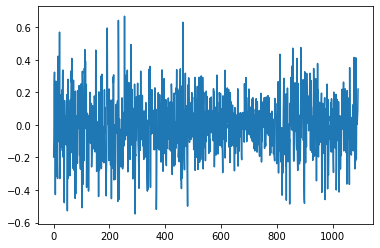

In [76]:
print("Nsamples : ", n_samples )
print((model.linear.bias).shape)
plt.plot((model2.linear.weight[0,2:].detach()))

In [178]:
model2.linear.weight[0,:]

tensor([ 1.8378, -1.7393, -0.1970,  ...,  0.0462,  0.0906,  0.2205],
       grad_fn=<SliceBackward0>)

# Asymmetric Laplacian - Layer-wise spectrum 

SVD decomposition of each layer to investigate the mode graph 

In [173]:
arch = [28*28, 50,50,10,50,50, 10]
optimizer = torch.optim.SGD
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 10

#for i in range(epochs):
    #Train : 
pipe.train(optimizer, 10, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    
   
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())



Epoch 1
-------------------------------
Epoch training loss: 2.300289 	Epoch training accuracy: 10.32%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 10.34%,                 Avg loss: 2.284804 

Epoch 2
-------------------------------
Epoch training loss: 2.067531 	Epoch training accuracy: 10.12%                                                                
Time taken for this epoch: 8.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 11.40%,                 Avg loss: 1.985819 

Epoch 3
-------------------------------
Epoch training loss: 1.768871 	Epoch training accuracy: 26.09%                                      500 ]                     
Time taken for this epoch: 8.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 36.61%,                 Avg loss: 1.536082 

Epoch 4
-------------------------------
Epoch training loss: 1.355203 	Ep

In [179]:
epsilon = 0.2
n_batch = 300 #Number of batch used to generate the dataset 

lapOp = LaplacianOperator(weights,positivation='relu')
u,v = lapOp.diagonalize()

activ = torch.zeros((3,n_batch*32,len(u)))
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)
predLabel = torch.zeros(3,n_batch*32)


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
    
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    label[k_batch*32:(k_batch+1)*32]=target
    for alter in range(3):
        predLabel[alter][k_batch*32:(k_batch+1)*32]=activ[alter][k_batch*32:(k_batch+1)*32,-10:].argmax(dim=1)
    
    k_batch+=1
    if k_batch>=n_batch:
        break 
print(activ.shape)

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

torch.Size([3, 9600, 1004])


In [175]:
(predLabel[1]==label).sum()/len(label)

tensor(0.0832)

In [180]:
S= []
V = []
U=[]
for layer in weights:
    u,s,v= torch.svd(layer)
    U.append(u.to('cpu'))
    S.append(s.to('cpu'))
    V.append(v.to('cpu'))

In [177]:
S

[tensor([2.1952, 2.1379, 2.0353, 1.9216, 1.8779, 1.7975, 1.6990, 1.5886, 1.4500,
         1.4309, 1.3008, 1.2302, 1.2194, 1.1544, 1.1057, 1.0994, 1.0477, 1.0310,
         0.9941, 0.9479, 0.9218, 0.9176, 0.8340, 0.8283, 0.8171, 0.8024, 0.7731,
         0.7647, 0.7421, 0.7289, 0.7081, 0.7064, 0.6853, 0.6670, 0.6556, 0.6511,
         0.6426, 0.6370, 0.6253, 0.6191, 0.6094, 0.6062, 0.5995, 0.5895, 0.5832,
         0.5693, 0.5544, 0.5450, 0.5252, 0.5168]),
 tensor([2.5716, 2.1114, 1.9522, 1.6575, 1.3198, 1.2358, 1.1539, 1.0854, 0.9884,
         0.9281, 0.9157, 0.8877, 0.8458, 0.8177, 0.7776, 0.7418, 0.7292, 0.7131,
         0.6958, 0.6774, 0.6192, 0.6098, 0.6002, 0.5376, 0.5144, 0.4979, 0.4719,
         0.4575, 0.4275, 0.4141, 0.3904, 0.3753, 0.3357, 0.3056, 0.2943, 0.2813,
         0.2520, 0.2376, 0.2151, 0.2004, 0.1739, 0.1687, 0.1342, 0.1250, 0.1004,
         0.0913, 0.0589, 0.0492, 0.0364, 0.0103]),
 tensor([2.6894, 2.0448, 2.0044, 1.5092, 0.7752, 0.6382, 0.5939, 0.5217, 0.4836,
       

<span style="color:red">WARNING : The next cell collapses activ to just one class</span>.

In [178]:


target = 6
activLab=[]
idxs = activ[(predLabel==target)]
base=0
for alter in range(3):
    activLab.append(activ[alter][base:base+(predLabel[alter]==target).sum().item()])
    base+=(predLabel[alter]==target).sum().item()
activ=activLab

#activ is not a tensor anymore but a list of tensor (and they do not have necessarily the same size)

In [9]:
idxs = label==7

activ=activ[:,idxs,:]
print(activ.shape)

# This cell uses a supervision signal (the true labels) ! Of course adversarial attacks will be different 

torch.Size([3, 1029, 964])


## Average plots 

In [181]:
import pandas as pd 
import plotly.express as px



base = 0
for i in range(len(arch)-1):
    inDim = arch[i]
    df = pd.DataFrame({'eigenValues': [], 'Spectrum': [], 'Error':[],'Type' :[]})
    print("Layer : ",i," In : ", arch[i], " Out :",arch[i+1])
    for alter,color in enumerate(['Normal','Attacked','Noised']):
        
        projections = activ[alter][:,base:(base+inDim)]@V[i]
        #Standard deviation error 
        dataset = pd.DataFrame({'eigenValues': S[i], 'Spectrum': projections.mean(dim=0), 'Error':projections.std(dim=0),'Type' :color})
        #Linfinity error 
        #dataset = pd.DataFrame({'eigenValues': eigenValues[i], 'Spectrum': projections.mean(dim=0), 'Error':(projections.max(dim=0)[0]-projections.min(dim=0)[0])/2,'Type' :color})
        
        df = pd.concat([df,dataset])
        
        
        #plt.scatter(eigenValues[i],projections.mean(dim=0),color=color)
        #plt.scatter(range(len(eigenValues[i])),projections.mean(dim=0),color=color)
        
    fig = px.scatter(df, x="eigenValues", y="Spectrum", error_y="Error",color ="Type")
        
    fig.show()
        
        
    plt.show()
        
    base+=inDim 


 

Layer :  0  In :  784  Out : 50


Layer :  1  In :  50  Out : 50


Layer :  2  In :  50  Out : 10


Layer :  3  In :  10  Out : 50


Layer :  4  In :  50  Out : 50


Layer :  5  In :  50  Out : 10


## Spectral modes adjacency

#### Activations of modes : 
- Forward def : use Vi.T@x_i to get m_i 
- Backward def : use Ui^⁽-1)@x_i to get m_i

In [183]:
#Matrix containing the activation for each mode 
activM = []


for alter in range(3):
    baseM = 0
    baseN=0
    modeActiv = torch.zeros((activ[alter].shape[0],sum(arch[1:])))
    for vm in V:
        modeActiv[:,baseM:(baseM+vm.shape[1])] = activ[alter][:,baseN:(baseN+vm.shape[0])]@vm
        baseN+=vm.shape[0]
        baseM+=vm.shape[1]
        
    activM.append(modeActiv)
    



In [187]:
for test in V:
    print(test.shape)

torch.Size([784, 50])
torch.Size([50, 50])
torch.Size([50, 10])
torch.Size([10, 10])
torch.Size([50, 50])
torch.Size([50, 10])


torch.Size([9600, 220])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (9600x220 and 180x180)

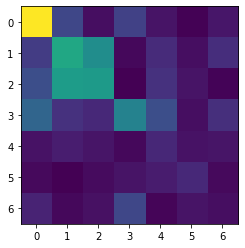

In [186]:
# With no weights (just the topology) : V[i+1].T@U[i]@torch.diag(S[i])
#With SVD weights 
adjacency = [V[i+1].T@U[i]@torch.diag(S[i]) for i in range(len(arch)-2)]
lapOp = LaplacianOperator(adjacency,positivation='abs',normalize='none')
u,v = lapOp.diagonalize()

plt.imshow(torch.abs(adjacency[-4])[0:7,0:7])



# change basis to laplacian eigenvectors 
activML = []
for alter in range(3):
    print(activM[alter].shape)
    activML.append(activM[alter]@v)



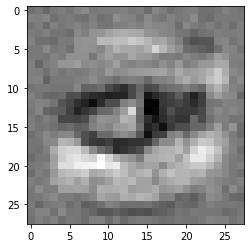

In [167]:
print28x28tensor(V[0].T[0].reshape(28*28))

In [185]:
#Visualisation of mode activations on laplacian eigenbasis 
df = pd.DataFrame({'eigenValue': [], 'Spectrum': [], 'Error':[],'Type' :[]})
for alter,color in enumerate(['Normal','Attacked','Noised']):
        
        #Standard deviation error 
        dataset = pd.DataFrame({'eigenValue': u, 'Spectrum': activML[alter][:,:].mean(dim=0), 'Error':activML[alter][:,:].std(dim=0),'Type' :color})
        #Linfinity error 
        #dataset = pd.DataFrame({'eigenValues': eigenValues[i], 'Spectrum': projections.mean(dim=0), 'Error':(projections.max(dim=0)[0]-projections.min(dim=0)[0])/2,'Type' :color})
        
        df = pd.concat([df,dataset])
        
        
        #plt.scatter(eigenValues[i],projections.mean(dim=0),color=color)
        #plt.scatter(range(len(eigenValues[i])),projections.mean(dim=0),color=color)
        
fig = px.scatter(df, x="eigenValue", y="Spectrum", error_y="Error",color ="Type")
        
fig.show()

IndexError: list index out of range

In [169]:
df['Spectrum'].min()

-5.183967113494873

In [170]:
arch

[784, 10, 10, 10, 10, 10, 10]

tensor(10.3524)


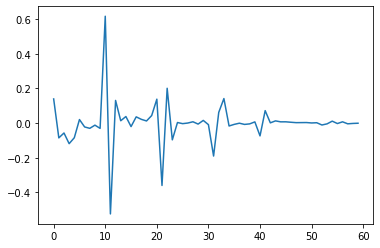

In [171]:
idx =-3
v=v.to('cpu')
print(u[idx])
plt.plot(v.T[idx])

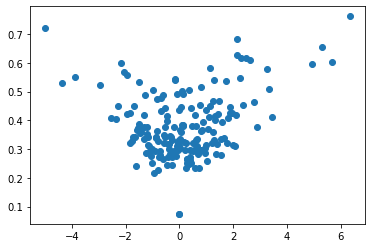

In [43]:
maxVal,argmaxVal = torch.abs(v).max(dim=0)
plt.scatter(u,maxVal)

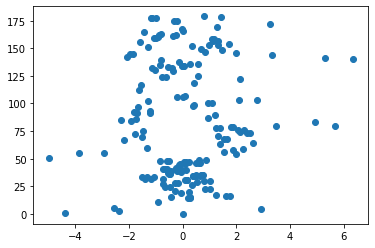

In [44]:
plt.scatter(u,argmaxVal)

## Effective network visualisation

In [151]:
S

[tensor([2.9592, 2.3787, 2.2766, 1.9909, 1.7845, 1.7156, 1.4253, 1.2833, 1.1965,
         1.0930]),
 tensor([1.9517, 1.8784, 1.8276, 1.4549, 0.8735, 0.6875, 0.6049, 0.2929, 0.1825,
         0.0798]),
 tensor([2.1998, 1.8891, 1.6154, 1.3208, 0.6608, 0.5837, 0.4987, 0.3464, 0.1923,
         0.0943]),
 tensor([2.0188, 1.8927, 1.6767, 1.4969, 0.7629, 0.4174, 0.2947, 0.2449, 0.2109,
         0.0501]),
 tensor([2.1589, 2.0442, 1.8387, 1.2876, 0.7316, 0.4736, 0.3652, 0.3199, 0.1935,
         0.0484]),
 tensor([2.8249, 1.7426, 1.6665, 1.2865, 1.1515, 1.0851, 0.6515, 0.4731, 0.3527,
         0.1208])]

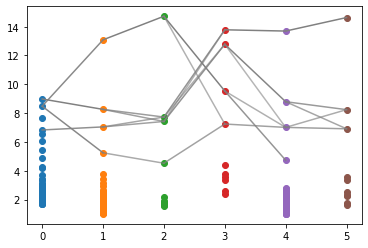

In [188]:
def y_scale(x):
    return torch.exp(x)

#Nodes 
for i in range(len(S)):
    plt.scatter(len(S[i])*[i],y_scale(S[i]))
    
#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if E[i,j]>8e-1:
                plt.plot([k,k+1],[y_scale(S[k][j]),y_scale(S[k+1][i])],color='grey',alpha=((E[i,j]/E.max())**0.5).item()) #Peut-être j,i
plt.show()

In [104]:
E[:,2]

tensor([0.6901, 0.7383, 0.1384, 1.7609, 0.3284, 0.0362, 0.2217, 0.1405, 0.0062,
        0.0451])

## Layer fusion 

Si les attaques adversariales proviennent de la linéarité du réseau alors on peut peut-être remplacer le réseau par la composition de tous ses layers. 
Maybe SVD pruning would improve performances here.

In [105]:
S

[tensor([2.0732, 1.9927, 1.9361, 1.8471, 1.7407, 1.6675, 1.6343, 1.6027, 1.5588,
         1.4883, 1.4264, 1.3738, 1.3339, 1.3096, 1.2717, 1.2596, 1.2021, 1.1728,
         1.1590, 1.1324, 1.1124, 1.0992, 1.0873, 1.0636, 1.0570, 1.0487, 1.0362,
         1.0325, 1.0128, 1.0111, 1.0025, 0.9991, 0.9917, 0.9898, 0.9832, 0.9821,
         0.9778, 0.9720, 0.9699, 0.9637, 0.9607, 0.9586, 0.9509, 0.9502, 0.9452,
         0.9426, 0.9382, 0.9375, 0.9330, 0.9285, 0.9244, 0.9229, 0.9224, 0.9178,
         0.9131, 0.9114, 0.9065, 0.9057, 0.9016, 0.8991, 0.8935, 0.8922, 0.8897,
         0.8886, 0.8835, 0.8792, 0.8774, 0.8749, 0.8743, 0.8736, 0.8692, 0.8672,
         0.8664, 0.8622, 0.8613, 0.8565, 0.8548, 0.8521, 0.8492, 0.8466, 0.8452,
         0.8419, 0.8389, 0.8351, 0.8325, 0.8310, 0.8283, 0.8259, 0.8233, 0.8213,
         0.8185, 0.8163, 0.8132, 0.8111, 0.8100, 0.8095, 0.8063, 0.8051, 0.8026,
         0.8014, 0.7971, 0.7957, 0.7937, 0.7918, 0.7901, 0.7879, 0.7863, 0.7840,
         0.7818, 0.7794, 0.7

In [106]:
def accuracy(W,dl_ts):
    ## Evaluation of W accuracy 
    total = 0
    score= 0
    for a in dl_ts:
        imgs=a[0].reshape(a[0].shape[0],784)
        logits = W@imgs.T
        score+=(logits.argmax(dim=0)==a[1]).sum()
        total+=len(a[1])

    
    
    return (100*score/total).item()

## Linear Condensed Network : W

W = weights[0]
for layer in weights[1:]:
    W=layer@W
print(W.shape)
W=W.to('cpu')

print("Accuracy linear condensed : ",accuracy(W,dl_ts), " %")

def condensed(t):## With network SVD pruning : 
    W=torch.eye(V[0].T.shape[1])
    for i in range(len(S)):
        W=V[i].T@W
        W = torch.diag(S[i]*(S[i]>=t))@W
        W=U[i]@W
    return W

print("Accuracy linear condensed with pruning : ",accuracy(condensed(1),dl_ts), " %")

torch.Size([10, 784])
Accuracy linear condensed :  43.619998931884766  %
Accuracy linear condensed with pruning :  47.22999954223633  %


In [111]:
## Best pruning threshold 
threshold = 0.4*torch.tensor(range(20))
acc = []
for t in threshold: 
    print(t)
    W=torch.eye(V[0].T.shape[1])
    for i in range(len(S)):
        W=V[i].T@W
        W = torch.diag(S[i]*(S[i]>t))@W
        W=U[i]@W
    acc.append(accuracy(W,dl_ts))

tensor(0.)
tensor(0.4000)
tensor(0.8000)
tensor(1.2000)
tensor(1.6000)
tensor(2.)
tensor(2.4000)
tensor(2.8000)
tensor(3.2000)
tensor(3.6000)
tensor(4.)
tensor(4.4000)
tensor(4.8000)
tensor(5.2000)
tensor(5.6000)
tensor(6.)
tensor(6.4000)
tensor(6.8000)
tensor(7.2000)
tensor(7.6000)


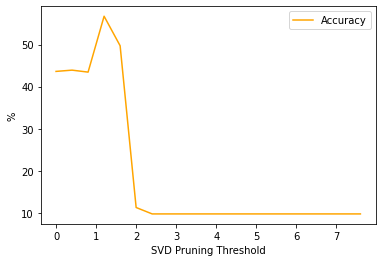

In [112]:
plt.plot(threshold,acc,color='orange',label='Accuracy')
plt.xlabel('SVD Pruning Threshold')
plt.ylabel('%')
plt.legend()

Is the 1 threshold the best in all conditions ? 

## Adversarial attacks on condensed SVD spectra 

In [113]:
W = condensed(0)
Uc,Sc,Vc = torch.svd(W)


df = pd.DataFrame({'eigenValues': [], 'Spectrum': [], 'Error':[],'Type' :[]})
print("Condensed Network, In : ", W.shape[1], " Out :",W.shape[0])
for alter,color in enumerate(['Normal','Attacked','Noised']):

    projections = activ[alter][:,:28*28]@Vc
    #Standard deviation error 
    dataset = pd.DataFrame({'eigenValues': Sc, 'Spectrum': projections.mean(dim=0), 'Error':projections.std(dim=0),'Type' :color})
    #Linfinity error 
    #dataset = pd.DataFrame({'eigenValues': eigenValues[i], 'Spectrum': projections.mean(dim=0), 'Error':(projections.max(dim=0)[0]-projections.min(dim=0)[0])/2,'Type' :color})

    df = pd.concat([df,dataset])


    #plt.scatter(eigenValues[i],projections.mean(dim=0),color=color)
    #plt.scatter(range(len(eigenValues[i])),projections.mean(dim=0),color=color)

fig = px.scatter(df, x="eigenValues", y="Spectrum", error_y="Error",color ="Type")

fig.show()


plt.show()

Condensed Network, In :  784  Out : 10


C'est choquant à quel point on n'observe pas de différences sur les distributions statistiques, on ne regarde surement pas les choses dans la bonne base. Essai de régression logistique sur les modes pour y voir plus clair. 

## Logistic regression on layer mode activation 

In [114]:
from sklearn.model_selection import train_test_split 
from tqdm import tqdm 
import numpy as np 

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)     
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    def train(self,optimizer,criterion,epochs,X_train,X_test,y_train,y_test):
        losses = []
        losses_test = []
        Iterations = []
        iter = 0
        for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
            x = X_train
            labels = y_train
            optimizer.zero_grad() # Setting our stored gradients equal to zero
            outputs = self(X_train)
            loss = criterion(torch.squeeze(outputs), labels) 

            loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

            optimizer.step() # Updates weights and biases with the optimizer (SGD)

            iter+=1
            if iter%1000==0:
                with torch.no_grad():
                    # Calculating the loss and accuracy for the test dataset
                    correct_test = 0
                    total_test = 0
                    outputs_test = torch.squeeze(self(X_test))
                    loss_test = criterion(outputs_test, y_test)

                    predicted_test = outputs_test.round().detach().numpy()
                    total_test += y_test.size(0)
                    correct_test += np.sum(predicted_test == y_test.detach().numpy())
                    self.correct_idxs = (predicted_test == y_test.detach().numpy())
                    accuracy_test = 100 * correct_test/total_test
                    losses_test.append(loss_test.item())

                    # Calculating the loss and accuracy for the train dataset
                    total = 0
                    correct = 0
                    total += y_train.size(0)
                    correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                    accuracy = 100 * correct/total
                    losses.append(loss.item())
                    Iterations.append(iter)

                    print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                    print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")



#activ = activ.to('cpu')
                    
# activ to regress 
activReg = activM

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2],activReg[1]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 8000
input_dim = activReg[0].shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

Training Epochs:  13%|██▋                  | 1045/8000 [00:04<00:28, 246.52it/s]

Iteration: 1000. 
Test - Loss: 0.2219732254743576. Accuracy: 92.32954545454545
Train -  Loss: 0.2110947221517563. Accuracy: 92.7549751243781



Training Epochs:  26%|█████▎               | 2043/8000 [00:08<00:25, 236.69it/s]

Iteration: 2000. 
Test - Loss: 0.2037564218044281. Accuracy: 93.19760101010101
Train -  Loss: 0.18964172899723053. Accuracy: 93.54788557213931



Training Epochs:  38%|███████▉             | 3042/8000 [00:12<00:20, 246.25it/s]

Iteration: 3000. 
Test - Loss: 0.1932132989168167. Accuracy: 93.51325757575758
Train -  Loss: 0.1767224669456482. Accuracy: 93.98320895522389



Training Epochs:  50%|██████████▌          | 4034/8000 [00:16<00:16, 241.86it/s]

Iteration: 4000. 
Test - Loss: 0.18563345074653625. Accuracy: 93.73421717171718
Train -  Loss: 0.16728118062019348. Accuracy: 94.35634328358209



Training Epochs:  63%|█████████████▏       | 5034/8000 [00:20<00:12, 245.60it/s]

Iteration: 5000. 
Test - Loss: 0.1796765923500061. Accuracy: 93.90782828282828
Train -  Loss: 0.15981541574001312. Accuracy: 94.56623134328358



Training Epochs:  75%|███████████████▊     | 6032/8000 [00:24<00:08, 242.12it/s]

Iteration: 6000. 
Test - Loss: 0.1747586727142334. Accuracy: 93.82891414141415
Train -  Loss: 0.1536467969417572. Accuracy: 94.77611940298507



Training Epochs:  88%|██████████████████▍  | 7032/8000 [00:28<00:03, 244.94it/s]

Iteration: 7000. 
Test - Loss: 0.1705685257911682. Accuracy: 94.04987373737374
Train -  Loss: 0.1484016478061676. Accuracy: 94.94713930348259



Training Epochs: 100%|█████████████████████| 8000/8000 [00:32<00:00, 243.90it/s]

Iteration: 8000. 
Test - Loss: 0.16691997647285461. Accuracy: 94.12878787878788
Train -  Loss: 0.14384955167770386. Accuracy: 95.1337064676617



- The removal of the input information reduces by 10% the accuracy (80% )
- Using mode level information instead of node leve information improves training speed and generalization by a few points 


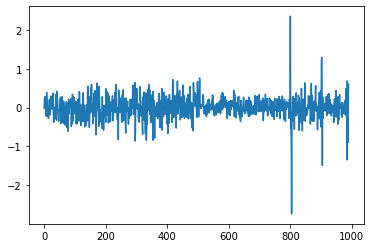

In [115]:
plt.plot(reg.linear.weight.detach().to('cpu').T)

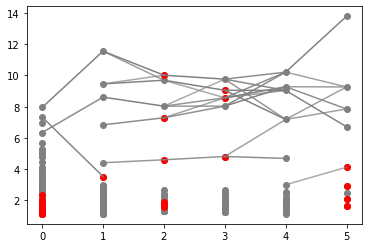

In [119]:
attention = torch.abs(reg.linear.weight.detach().to('cpu').T)
attention=attention.reshape(len(attention))
def y_scale(x):
    return torch.exp(x)

#Nodes 
base = 0 
for i in range(len(S)):
    plt.scatter(len(S[i])*[i],y_scale(S[i]),color='grey')
    idxs = attention[base:(base+len(S[i]))]>(3*attention.mean())
    Sred = S[i][idxs]
    plt.scatter(len(Sred)*[i],y_scale(Sred),color='red')
    base+=len(S[i])
    
    
#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if E[i,j]>8e-1:
                plt.plot([k,k+1],[y_scale(S[k][j]),y_scale(S[k+1][i])],color='grey',alpha=((E[i,j]/E.max())**0.5).item()) #Peut-être j,i
plt.show()

In [120]:
def test(vec):
    
    epochs = 2000
    input_dim = max(vec.shape)
    vec = vec.reshape(1,input_dim)
    learning_rate = 0.01

    reg2 = LogisticRegression(input_dim)

    with torch.no_grad():
        # Initialize using previous model : 
        reg2.linear.weight = nn.Parameter(vec)
        reg2.linear.bias = nn.Parameter(torch.zeros(1))

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam([reg2.linear.bias], lr=learning_rate)



    reg2.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)
    
    return reg2.correct_idxs 


In [121]:
reg.linear.weight.detach().to('cpu').shape

torch.Size([1, 990])

In [123]:
#Testing the effectiveness of pruned linear regressed vector 
idxs = test(reg.linear.weight.detach().to('cpu')*(attention>3*attention.mean()))

Training Epochs:  52%|██████████▉          | 1039/2000 [00:04<00:04, 231.73it/s]

Iteration: 1000. 
Test - Loss: 0.751367449760437. Accuracy: 68.10290404040404
Train -  Loss: 0.7628996968269348. Accuracy: 67.54508706467662



Training Epochs: 100%|█████████████████████| 2000/2000 [00:08<00:00, 237.07it/s]

Iteration: 2000. 
Test - Loss: 0.751367449760437. Accuracy: 68.10290404040404
Train -  Loss: 0.7628996968269348. Accuracy: 67.54508706467662



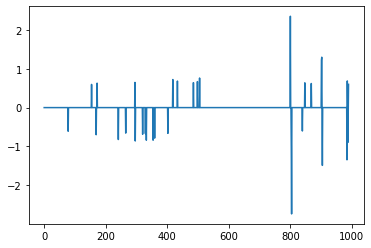

In [126]:
plt.plot((reg.linear.weight.detach().to('cpu')*(attention>3*attention.mean())).reshape(max(reg.linear.weight.shape)))

Trying to craft a universal adversarial perturbation from logistic regression learning 

In [129]:
#activ = activ.to('cpu')
                    
# activ to regress 
activReg = activ

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2][:,:28*28],activReg[1][:,:28*28]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 5000
input_dim = X_train.shape[1]
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)
_=test(reg.linear.weight.detach())

Training Epochs:  21%|████▍                | 1051/5000 [00:03<00:12, 306.46it/s]

Iteration: 1000. 
Test - Loss: 0.29832231998443604. Accuracy: 89.15719696969697
Train -  Loss: 0.2877074182033539. Accuracy: 89.92537313432835



Training Epochs:  41%|████████▌            | 2050/5000 [00:06<00:09, 300.13it/s]

Iteration: 2000. 
Test - Loss: 0.26098063588142395. Accuracy: 90.56186868686869
Train -  Loss: 0.24354536831378937. Accuracy: 91.48009950248756



Training Epochs:  61%|████████████▊        | 3062/5000 [00:10<00:06, 309.00it/s]

Iteration: 3000. 
Test - Loss: 0.24357254803180695. Accuracy: 91.2405303030303
Train -  Loss: 0.2215227335691452. Accuracy: 92.41293532338308



Training Epochs:  81%|████████████████▉    | 4036/5000 [00:13<00:03, 292.10it/s]

Iteration: 4000. 
Test - Loss: 0.23305334150791168. Accuracy: 91.55618686868686
Train -  Loss: 0.20749755203723907. Accuracy: 92.98041044776119



Training Epochs: 100%|█████████████████████| 5000/5000 [00:16<00:00, 305.28it/s]


Iteration: 5000. 
Test - Loss: 0.2257966548204422. Accuracy: 91.6824494949495
Train -  Loss: 0.197416290640831. Accuracy: 93.28358208955224



Training Epochs:  52%|███████████          | 1048/2000 [00:03<00:03, 290.69it/s]

Iteration: 1000. 
Test - Loss: 0.22566348314285278. Accuracy: 91.72979797979798
Train -  Loss: 0.1972891390323639. Accuracy: 93.33022388059702



Training Epochs: 100%|█████████████████████| 2000/2000 [00:06<00:00, 296.87it/s]

Iteration: 2000. 
Test - Loss: 0.2255064845085144. Accuracy: 91.77714646464646
Train -  Loss: 0.19715924561023712. Accuracy: 93.42350746268657



In [48]:
X_train.shape

torch.Size([1250, 784])

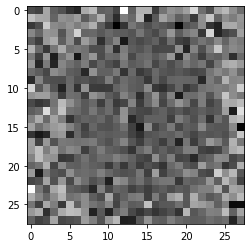

In [130]:
print28x28tensor(reg.linear.weight.detach().reshape(28*28))

In [132]:
uniAtt = reg.linear.weight.detach().reshape(1,28,28)
uniAtt = epsilon*uniAtt/max(uniAtt.max(),uniAtt.min())
uniAtt=epsilon*torch.sign(uniAtt)
uniAtt=uniAtt.to(DEVICE)

correct_pred=0 
correct_pred_under_attack=0
total_samples=0

for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = data+uniAtt
    
    correct_pred+=(target==pipe.model(data).argmax(dim=1)).sum()
    correct_pred_under_attack+=(target==pipe.model(data_perturbed).argmax(dim=1)).sum()
    total_samples+=len(target)
    
print("Correct predictions :             ", correct_pred/total_samples*100, " %")
print("Correct predictions under attack: ", correct_pred_under_attack/total_samples*100, " %")

Correct predictions :              tensor(98.6183, device='cuda:0')  %
Correct predictions under attack:  tensor(86.5900, device='cuda:0')  %


In [64]:
pipe.model(data).argmax(dim=1)

tensor([5, 9, 2, 2, 0, 9, 2, 4, 6, 7, 3, 1, 3, 6, 6, 2, 1, 2, 6, 0, 7, 8, 9, 2,
        9, 5, 1, 8, 3, 5, 6, 8], device='cuda:0')

## Looking in the trash (kernel of layers) 

In [133]:
from scipy.linalg import null_space

K=[]
for layer in weights:
    K.append(null_space(layer.to('cpu')))
    
activK = []
for alter in range(3):
    baseK = 0
    baseN=0
    modeActiv = torch.zeros((activ[alter].shape[0],arch[0]-arch[-1]))
    for ker in K :
        modeActiv[:,baseK:(baseK+ker.shape[1])] = activ[alter][:,baseN:(baseN+ker.shape[0])]@ker
        baseN+=ker.shape[0]
        baseK+=ker.shape[1]
        
    activK.append(modeActiv)
    



In [70]:
K[0].shape86.5900, dev

(784, 734)

How much linearly readable information is there in actiK ? Trying to regress it with logistic regression. 

In [134]:
activReg=activK

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2],activReg[1]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 8000
input_dim = activReg[0].shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

Training Epochs:  13%|██▋                  | 1033/8000 [00:03<00:22, 312.22it/s]

Iteration: 1000. 
Test - Loss: 0.263841450214386. Accuracy: 90.625
Train -  Loss: 0.25466278195381165. Accuracy: 90.98258706467662



Training Epochs:  26%|█████▍               | 2060/8000 [00:06<00:18, 317.58it/s]

Iteration: 2000. 
Test - Loss: 0.23896478116512299. Accuracy: 91.47727272727273
Train -  Loss: 0.2286112755537033. Accuracy: 91.62779850746269



Training Epochs:  38%|████████             | 3053/8000 [00:09<00:16, 308.82it/s]

Iteration: 3000. 
Test - Loss: 0.22631600499153137. Accuracy: 92.01388888888889
Train -  Loss: 0.2147224396467209. Accuracy: 92.21082089552239



Training Epochs:  51%|██████████▋          | 4048/8000 [00:12<00:12, 309.26it/s]

Iteration: 4000. 
Test - Loss: 0.21752646565437317. Accuracy: 92.39267676767676
Train -  Loss: 0.2048443704843521. Accuracy: 92.66169154228855



Training Epochs:  63%|█████████████▎       | 5058/8000 [00:16<00:09, 318.88it/s]

Iteration: 5000. 
Test - Loss: 0.21064332127571106. Accuracy: 92.6925505050505
Train -  Loss: 0.1970343142747879. Accuracy: 92.91822139303483



Training Epochs:  76%|███████████████▊     | 6044/8000 [00:19<00:06, 321.66it/s]

Iteration: 6000. 
Test - Loss: 0.2049301415681839. Accuracy: 92.88194444444444
Train -  Loss: 0.19053585827350616. Accuracy: 93.23694029850746



Training Epochs:  88%|██████████████████▌  | 7065/8000 [00:22<00:02, 322.77it/s]

Iteration: 7000. 
Test - Loss: 0.20002619922161102. Accuracy: 93.19760101010101
Train -  Loss: 0.18496528267860413. Accuracy: 93.52456467661692



Training Epochs: 100%|█████████████████████| 8000/8000 [00:25<00:00, 316.01it/s]

Iteration: 8000. 
Test - Loss: 0.19572371244430542. Accuracy: 93.2449494949495
Train -  Loss: 0.18009421229362488. Accuracy: 93.80441542288557



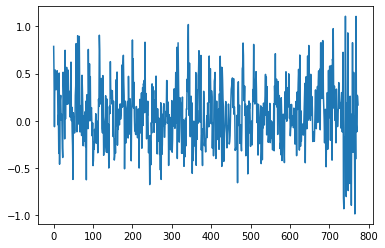

In [81]:
a = reg.linear.weight.detach().to('cpu').reshape(28*28-10)
plt.plot(a)

Trying to remove input information

In [86]:
activReg=activK

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[2][:,:(28*28-50)],activReg[1][:,:(28*28-50)]]), torch.cat([torch.zeros(len(activReg[2])),torch.ones(len(activReg[1]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 8000
input_dim = X_train.shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

Training Epochs:  13%|██▋                  | 1046/8000 [00:03<00:20, 331.51it/s]

Iteration: 1000. 
Test - Loss: 0.3421575129032135. Accuracy: 86.80555555555556
Train -  Loss: 0.34240198135375977. Accuracy: 86.47388059701493



Training Epochs:  26%|█████▍               | 2066/8000 [00:06<00:17, 335.69it/s]

Iteration: 2000. 
Test - Loss: 0.30048882961273193. Accuracy: 88.47853535353535
Train -  Loss: 0.2970874011516571. Accuracy: 88.2773631840796



Training Epochs:  38%|████████             | 3050/8000 [00:09<00:14, 334.35it/s]

Iteration: 3000. 
Test - Loss: 0.27863994240760803. Accuracy: 89.33080808080808
Train -  Loss: 0.27217987179756165. Accuracy: 89.59888059701493



Training Epochs:  50%|██████████▌          | 4035/8000 [00:12<00:11, 334.61it/s]

Iteration: 4000. 
Test - Loss: 0.2642088532447815. Accuracy: 90.0094696969697
Train -  Loss: 0.2552724778652191. Accuracy: 90.37624378109453



Training Epochs:  63%|█████████████▎       | 5048/8000 [00:15<00:08, 333.91it/s]

Iteration: 5000. 
Test - Loss: 0.25357502698898315. Accuracy: 90.59343434343434
Train -  Loss: 0.24260620772838593. Accuracy: 90.82711442786069



Training Epochs:  75%|███████████████▊     | 6034/8000 [00:18<00:05, 335.25it/s]

Iteration: 6000. 
Test - Loss: 0.2452206313610077. Accuracy: 90.9090909090909
Train -  Loss: 0.23255427181720734. Accuracy: 91.29353233830845



Training Epochs:  88%|██████████████████▌  | 7053/8000 [00:21<00:02, 329.44it/s]

Iteration: 7000. 
Test - Loss: 0.23837828636169434. Accuracy: 91.11426767676768
Train -  Loss: 0.2242717444896698. Accuracy: 91.5967039800995



Training Epochs: 100%|█████████████████████| 8000/8000 [00:24<00:00, 332.17it/s]

Iteration: 8000. 
Test - Loss: 0.23261070251464844. Accuracy: 91.2405303030303
Train -  Loss: 0.21726572513580322. Accuracy: 91.88432835820896



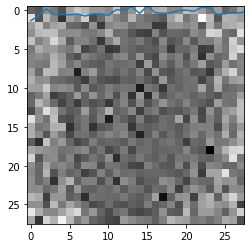

In [93]:
a = reg.linear.weight.detach().to('cpu').reshape(734)
plt.plot(a)
ker0 = torch.tensor(K[0])
print28x28tensor(ker0@(a.reshape(734,1)))

In [135]:
arch

[784, 500, 300, 100, 50, 30, 10]